<h1 align="center">Diseño e Implementación de Modelo de Regresión usando FC-DNN</h1>

El objetivo es predecir las variables objetivo: "Valoración general del teletrabajo", "Productividad en actual trabajo" y "Satisfacción en actual trabajo", en función de las características de los demás trabajadores, empleando aprendizaje automático profundo, concretamente, redes neuronales profundas totalmente conectadas.

### 1. Importar Librerías:

In [1]:
# Manipulación y Procesamiento de datos
import numpy as np
import pandas as pd

# Aprendizaje automático (profundo)
import sklearn
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Visualización de datos
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Generación de datos para Campana de Gauss
from scipy.stats import norm

# Manejo de archivos
import xlsxwriter
import os

C:\Users\zorri\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\zorri\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
print("Versiones de las librerías:")
print("- NumPy:", np.__version__)
print("- Pandas:", pd.__version__)

print("- Scikit-learn:", sklearn.__version__)
print("- TensorFlow:", tf.__version__)

print("- Matplotlib:", matplotlib.__version__)
print("- Seaborn:", sns.__version__)

print("- Xlsxwriter:", xlsxwriter.__version__)

Versiones de las librerías:
- NumPy: 1.26.4
- Pandas: 2.2.3
- Scikit-learn: 1.6.1
- TensorFlow: 2.18.0
- Matplotlib: 3.4.3
- Seaborn: 0.11.2
- Xlsxwriter: 3.0.5


In [3]:
import sys
print("Python", sys.version)

Python 3.9.7 (default, Sep 16 2021, 16:59:28) [MSC v.1916 64 bit (AMD64)]


### 2. Lectura del Dataset:

In [4]:
df_inicial = pd.read_excel("Trabajo_ Remoto vs Presencial (respuestas).xlsx")
df_inicial.head()

,Marca temporal,¿Cuál es tu edad?,¿Cuál es tu sexo?,¿Cuál es tu nacionalidad?,¿Cuál es tu nivel de estudios?,¿En qué sector trabajas?,¿Cuántos años de experiencia tiene en el entorno laboral?,¿Cuántas horas trabajas semanalmente?,¿Cuál es la modalidad laboral en tu actual puesto de trabajo?,¿Cómo describirías tu opinión actual sobre trabajar en remoto?,...,¿Cómo ha afectado el trabajo en remoto a tu productividad laboral?,¿Cómo describirías la comunicación en remoto con los compañeros del trabajo?,¿Cómo ha afectado el trabajo en remoto a su bienestar general?,¿Qué modalidad laboral prefieres en el futuro?,¿Crees que el trabajo en remoto se consolidará en su sector a largo plazo?,¿Crees que se necesitan cambios para conseguir la sostenibilidad del trabajo en remoto?,"En el caso de que la anterior pregunta sea afirmativa, ¿por qué has elegido ""Sí"" y qué cambios harías?",Valoración general del teletrabajo,¿Cuál dirías que es tu nivel de productividad en tu actual puesto de trabajo?,¿Cuál dirías que es tu nivel de satisfacción en tu actual puesto de trabajo?
0,2025-01-27 04:39:13.697,22,Hombre,Española,Estudios universitarios,Tecnología,1.5,8.0,Híbrido,2,...,2,2,2,Híbrido,Sí,No,NaN,NaN,NaN,NaN
1,2025-01-27 08:23:26.617,41,Hombre,Española,Estudios de postgrado,Tecnología,20.0,48.0,Remoto,2,...,1,1,3,Híbrido,Sí,Sí,Mejorar trabajo en equipo,NaN,NaN,NaN
2,2025-01-27 10:26:14.847,22,Hombre,Española,Estudios universitarios,Tecnología,2.0,30.0,Híbrido,3,...,2,2,3,Híbrido,No,No,NaN,NaN,NaN,NaN
3,2025-01-27 10:34:53.536,22,Hombre,Española,Estudios universitarios,Tecnología,1.0,43.0,Remoto,3,...,2,2,2,Híbrido,Sí,Sí,NaN,NaN,NaN,NaN
4,2025-01-27 10:59:54.623,23,Hombre,Española,Estudios universitarios,Tecnología,1.0,40.0,Híbrido,1,...,2,1,2,Presencial 100%,No,Sí,Creo que por el camino que vamos las empresas ...,NaN,NaN,NaN


### 3. Preprocesamiento de datos:

In [5]:
df_inicial = df_inicial.drop(columns=['Marca temporal'])

# Crear la columna 'id'
df_inicial['id'] = range(1, len(df_inicial) + 1)

# Reorganizar las columnas para que 'id' sea la primera
df_inicial = df_inicial[['id'] + [col for col in df_inicial.columns if col != 'id']]

df_modif = df_inicial.rename(columns={'¿Cuál es tu edad?':'Edad', '¿Cuál es tu sexo?':'Sexo', '¿Cuál es tu nacionalidad?':'Nacionalidad', 
                       '¿Cuál es tu nivel de estudios?':'Nivel de estudios', '¿En qué sector trabajas?':'Sector laboral', 
                       '¿Cuántos años de experiencia tiene en el entorno laboral?':'Años de experiencia', 
                        '¿Cuántas horas trabajas semanalmente?':'Horas de trabajo semanales', '¿Cuál es la modalidad laboral en tu actual puesto de trabajo?':'Modalidad laboral actual',
                       '¿Cómo describirías tu opinión actual sobre trabajar en remoto?':'Opinión actual de teletrabajo', '¿Cómo calificarías el trabajo 100% remoto?':'Calificación trabajo remoto 100%',
                       '¿Crees que el trabajo desde fuera de la oficina es aceptado en su sector?':'Aceptación del trabajo en remoto en su sector', 
                       '¿Cuáles dirías que son las principales ventajas del trabajo en remoto? (Seleccione todas las opciones que creas necesarias)':'Ventajas teletrabajo',
                       '¿Cuáles dirías que son las principales desventajas del trabajo en remoto? (Seleccione todas las opciones que creas necesarias)':'Desventajas teletrabajo',
                       '¿Cuál es tu nivel de estrés?':'Nivel de estrés', '¿Qué condición de salud mental tienes? (Por ejemplo: ansiedad, depresión, "burnout", fatiga, etc.)':'Condición de salud mental',
                       '¿Con qué frecuencia realiza actividad física?':'Frecuencia de actividad física', '¿Cómo ha afectado el trabajo en remoto a tu productividad laboral?':'Efecto en productividad laboral del teletrabajo',
                       '¿Cómo describirías la comunicación en remoto con los compañeros del trabajo?':'Comunicación en remoto con compañeros',
                       '¿Cómo ha afectado el trabajo en remoto a su bienestar general?':'Efecto en bienestar del teletrabajo', '¿Qué modalidad laboral prefieres en el futuro?':'Modalidad preferida',
                       '¿Crees que el trabajo en remoto se consolidará en su sector a largo plazo?':'Consolidación del teletrabajo en el sector',
                       '¿Crees que se necesitan cambios para conseguir la sostenibilidad del trabajo en remoto? ':'Cambios para sostenibilidad teletrabajo',
                       'En el caso de que la anterior pregunta sea afirmativa, ¿por qué has elegido "Sí" y qué cambios harías?':'¿Qué debe cambiar?',
                       '¿Cuál dirías que es tu nivel de productividad en tu actual puesto de trabajo?':'Productividad en actual trabajo', 
                       '¿Cuál dirías que es tu nivel de satisfacción en tu actual puesto de trabajo?':'Satisfacción en actual trabajo'})

df_modif = df_modif.drop(columns=['Ventajas teletrabajo', 'Desventajas teletrabajo', '¿Qué debe cambiar?'])

print(df_modif.columns)
print(df_modif)

Index(['id', 'Edad', 'Sexo', 'Nacionalidad', 'Nivel de estudios',
       'Sector laboral', 'Años de experiencia', 'Horas de trabajo semanales',
       'Modalidad laboral actual', 'Opinión actual de teletrabajo',
       'Calificación trabajo remoto 100%',
       'Aceptación del trabajo en remoto en su sector', 'Nivel de estrés',
       'Condición de salud mental', 'Frecuencia de actividad física',
       'Efecto en productividad laboral del teletrabajo',
       'Comunicación en remoto con compañeros',
       'Efecto en bienestar del teletrabajo', 'Modalidad preferida',
       'Consolidación del teletrabajo en el sector',
       'Cambios para sostenibilidad teletrabajo',
       'Valoración general del teletrabajo', 'Productividad en actual trabajo',
       'Satisfacción en actual trabajo'],
      dtype='object')
      id  Edad    Sexo Nacionalidad        Nivel de estudios  \
0      1    22  Hombre     Española  Estudios universitarios   
1      2    41  Hombre     Española    Estudios de

In [6]:
df_modif.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 370 entries, 0 to 369
Data columns (total 24 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               370 non-null    int64  
 1   Edad                                             370 non-null    int64  
 2   Sexo                                             370 non-null    object 
 3   Nacionalidad                                     370 non-null    object 
 4   Nivel de estudios                                370 non-null    object 
 5   Sector laboral                                   370 non-null    object 
 6   Años de experiencia                              370 non-null    float64
 7   Horas de trabajo semanales                       370 non-null    float64
 8   Modalidad laboral actual                         370 non-null    object 
 9   Opinión actual de teletrabajo   

#### 3.1. Reemplazo de los datos.

Debido a que se realizó una encuesta para la recopilación de datos, se obtuvieron numerosas preguntas que abarcan un extenso abanico de respuestas, lo que implica la necesidad de procesar dichos datos.

##### 3.1.1. Nacionalidad.

In [7]:
# Obtener los valores únicos de la columna 'Nacionalidad'
valores_unicos_nacionalidad = df_modif['Nacionalidad'].unique()
print(valores_unicos_nacionalidad)

['Española' 'Colombiana ' 'Venezuela' 'Venezolana' 'Cubano' 'Cuba'
 'Cubana' 'Cubana ' 'cubana' 'American' 'Cubana y pronto española'
 'La Havana, Cuba' 'Cubano ' 'cuba' 'Marroquí' 'Cubana y española'
 'Italiano' 'colombiana' 'Brasileira ' 'Ecuatoriano' 'Mexicana'
 'Colombiana' 'Argentina' 'CHILENA' 'Rumana ' 'Mexicana ' 'Dominicana '
 'Dominicana' 'Boliviana' 'Argentina española' 'Ecuatoriana' 'Honduras'
 'Bolivia' 'peruano' 'Bolivia ' 'Peruana' 'Alemán' 'Portugal ' 'Mexicano '
 'El Salvador' 'Alemana']


In [8]:
# Crear un diccionario para mapear las nacionalidades originales a las nuevas (clave:valor)
mapeo_nacionalidades = {
    'Colombiana ': 'Colombiana',
    'Venezuela': 'Venezolana',
    'Cubano': 'Cubana',
    'Cuba': 'Cubana',
    'Cubana ': 'Cubana',
    'cubana': 'Cubana',
    'Cubano ': 'Cubana',
    'American': 'Americana',
    'Cubana y pronto española': 'Cubana',
    'La Havana, Cuba': 'Cubana',
    'cuba': 'Cubana',
    'Cubana y española': 'Cubana',
    'Italiano': 'Italiana',
    'colombiana': 'Colombiana',
    'Brasileira ': 'Brasileña',
    'Ecuatoriano': 'Ecuatoriana',
    'CHILENA': 'Chilena',
    'Rumana ': 'Rumana',
    'Mexicana ': 'Mexicana',
    'Dominicana ': 'Dominicana',
    'Argentina española': 'Argentina',
    'Honduras': 'Hondureña',
    'Bolivia': 'Boliviana', 
    'Alemán': 'Alemana',
    'peruano': 'Peruana',
    'Bolivia ': 'Boliviana',
    'Portugal ': 'Portuguesa',
    'Mexicano ': 'Mexicana', 
    'El Salvador': 'Salvadoreña'
}

# Modificar los registros de la columna 'Nacionalidad'
df_modif['Nacionalidad'] = df_modif['Nacionalidad'].replace(mapeo_nacionalidades)

# Obtener los valores únicos de la columna 'Nacionalidad'
valores_unicos_nacionalidad = df_modif['Nacionalidad'].unique()
print(valores_unicos_nacionalidad)

['Española' 'Colombiana' 'Venezolana' 'Cubana' 'Americana' 'Marroquí'
 'Italiana' 'Brasileña' 'Ecuatoriana' 'Mexicana' 'Argentina' 'Chilena'
 'Rumana' 'Dominicana' 'Boliviana' 'Hondureña' 'Peruana' 'Alemana'
 'Portuguesa' 'Salvadoreña']


##### 3.1.2. Nivel de estudios.

In [9]:
# Obtener los valores únicos de la columna 'Nivel de estudios'
valores_unicos_estudios = df_modif['Nivel de estudios'].unique()
print(valores_unicos_estudios)

['Estudios universitarios' 'Estudios de postgrado' 'Formación profesional'
 'Educación secundaria' 'Doctorado' 'COU' 'Bachiller' 'Bachiller '
 'bachiller' 'Autodidacta' 'Técnico Bachiller'
 'Director de Ciberseguridad' 'Doctora en Economía' ' Bachillerato']


In [10]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Nivel de estudios'] = df_modif['Nivel de estudios'].str.strip()

# Crear un diccionario para mapear los niveles de estudio originales a las nuevas (clave:valor // key:value)
mapeo_estudios = {
    'Doctora en Economía': 'Doctorado',
    'COU': 'Educación secundaria',
    'Bachiller': 'Bachillerato',
    'Bachiller ': 'Bachillerato',
    'bachiller': 'Bachillerato',
    'Autodidacta': 'Bachillerato',
    'Técnico Bachiller': 'Bachillerato',
    'Director de Ciberseguridad': 'Estudios universitarios'
}

# Modificar los registros de la columna 'Nivel de estudios'
df_modif['Nivel de estudios'] = df_modif['Nivel de estudios'].replace(mapeo_estudios)

# Obtener los valores únicos de la columna 'Nivel de estudios'
valores_unicos_estudios = df_modif['Nivel de estudios'].unique()
print(valores_unicos_estudios)

['Estudios universitarios' 'Estudios de postgrado' 'Formación profesional'
 'Educación secundaria' 'Doctorado' 'Bachillerato']


##### 3.1.3. Sector laboral.

In [11]:
# Obtener los valores únicos de la columna 'Sector laboral'
valores_unicos_sector = df_modif['Sector laboral'].unique()
print(valores_unicos_sector)

['Tecnología' 'Servicios' 'Salud y Medicina' 'Funcionaria ' 'Inmobiliario'
 'Banca' 'Quimico ' 'Automoción ' 'Industria ' 'Automocion/Renting'
 'Marketing digital ' 'Educación' 'Recursos humanos' 'COMERCIO'
 'Telemarketing ' 'Distribución y exportación ' 'tercer sector'
 'Administracion Local' 'Fotografía' 'Admon' 'Seguros' 'Consultoría'
 'Logistica' 'Industria petrolera' 'Freelance' 'Agricultura '
 'Desarrollo web' 'marketing digital' 'Turismo'
 'Consultoría y servicios informáticos' 'Ciencia y tecnología '
 'Comunicación y Marketing ' 'Contabilidad'
 'Comunicación social (Marketing)' 'Edición de video ' 'Empresarial '
 'Informática ' 'Marketing y diseño gráfico ' 'Estudio ' 'Ventas'
 'Marketing ' 'Administración Pública' 'Tercer sector'
 'Marketing, comunicación ' 'Mercadeo ' 'Seguridad ' 'GRAN CONSUMO'
 'Master en Economia y Finanzas ' 'Organizaciones internacionales'
 'No trabajo' 'Marketing' 'Manufactura '
 'Actualmente no trabajo y necesito empleo' 'Diseño' 'Investigación'
 'Publ

In [12]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Sector laboral'] = df_modif['Sector laboral'].str.strip()

# Crear un diccionario para mapear los niveles de estudio originales a las nuevas (clave:valor // key:value)
mapeo_sector = {
    'Tecnología': 'Tecnología y Ciencia',
    'Desarrollo web': 'Tecnología y Ciencia',
    'Consultoría y servicios informáticos': 'Tecnología y Ciencia',
    'Edición de video': 'Tecnología y Ciencia',
    'Informática': 'Tecnología y Ciencia',
    'Ciencia y tecnología': 'Tecnología y Ciencia',
    'ingeniería': 'Tecnología y Ciencia',
    'Informatica': 'Tecnología y Ciencia',
    'multimedia audiovisual': 'Tecnología y Ciencia',
    'publicidasd': 'Tecnología y Ciencia',
    'Tecnología y audiovisual': 'Tecnología y Ciencia',
    'Energia': 'Tecnología y Ciencia',
    'Videojuegos': 'Tecnología y Ciencia',
    
    'Farmacéutica': 'Salud y Medicina',
    
    'Servicios': 'Servicios y Comercio',
    'Telemarketing': 'Servicios y Comercio',
    'Distribución y exportación': 'Servicios y Comercio',
    'COMERCIO': 'Servicios y Comercio',
    'GRAN CONSUMO': 'Servicios y Comercio',
    'Turismo': 'Servicios y Comercio',
    'Ventas': 'Servicios y Comercio',
    'Tercer sector': 'Servicios y Comercio',
    'tercer sector': 'Servicios y Comercio',
    'Mercadeo': 'Servicios y Comercio',
    'Ocio': 'Servicios y Comercio',
    'Seguridad': 'Servicios y Comercio',
    
    'Funcionaria': 'Administración y Sector Público',
    'Administración Pública': 'Administración y Sector Público',
    'Administracion Local': 'Administración y Sector Público',
    'Admon': 'Administración y Sector Público',
    'Administrativo': 'Administración y Sector Público',
    'administracion y gestion': 'Administración y Sector Público',
    
    
    'Banca': 'Finanzas y Negocios',
    'Contabilidad': 'Finanzas y Negocios',
    'Master en Economia y Finanzas': 'Finanzas y Negocios',
    'Empresarial': 'Finanzas y Negocios',
    'Seguros': 'Finanzas y Negocios',
    'Consultoría': 'Finanzas y Negocios',
    'Inmobiliario': 'Finanzas y Negocios',
    'Organizaciones internacionales': 'Finanzas y Negocios',
    'Investigación de mercados': 'Finanzas y Negocios',
    'Atención al cliente y ventas': 'Finanzas y Negocios',
    'Servicio legales': 'Finanzas y Negocios',
    'Economía y empresa': 'Finanzas y Negocios',
    
    'Marketing digital': 'Marketing y Comunicación',
    'marketing digital': 'Marketing y Comunicación',
    'Comunicación y Marketing': 'Marketing y Comunicación',
    'Comunicación social (Marketing)': 'Marketing y Comunicación',
    'Marketing, comunicación': 'Marketing y Comunicación',
    'Publicidad': 'Marketing y Comunicación',
    'Diseño': 'Marketing y Comunicación',
    'Marketing y diseño gráfico': 'Marketing y Comunicación',
    'Fotografía': 'Marketing y Comunicación',
    'Marketing': 'Marketing y Comunicación',
    'marketing': 'Marketing y Comunicación',
    'Comunicación': 'Marketing y Comunicación',
    'Diseño y comunicación': 'Marketing y Comunicación',
    
    
    'Quimico': 'Industria y Manufactura',
    'Automoción': 'Industria y Manufactura',
    'Automocion/Renting': 'Industria y Manufactura',
    'Industria': 'Industria y Manufactura',
    'Industria petrolera': 'Industria y Manufactura',
    'Manufactura': 'Industria y Manufactura',
    
    'Agricultura': 'Agricultura y Medio Ambiente',
    
    'RRHH': 'Recursos Humanos',
    'Recursos humanos': 'Recursos Humanos',
    'Ciencias sociales (Recursos Humanos)': 'Recursos Humanos'
}

df_modif = df_modif[~df_modif['Sector laboral'].isin(['No trabajo', 'Actualmente no trabajo y necesito empleo', 'Estudio', 'estudiante', 'Estudiante'])]  # Eliminar registros donde no se trabaje

# Modificar los registros de la columna 'Sector laboral'
df_modif['Sector laboral'] = df_modif['Sector laboral'].replace(mapeo_sector)

# Obtener los valores únicos de la columna 'Sector laboral'
valores_unicos_sector = df_modif['Sector laboral'].unique()
print(valores_unicos_sector)

['Tecnología y Ciencia' 'Servicios y Comercio' 'Salud y Medicina'
 'Administración y Sector Público' 'Finanzas y Negocios'
 'Industria y Manufactura' 'Marketing y Comunicación' 'Educación'
 'Recursos Humanos' 'Logistica' 'Freelance' 'Agricultura y Medio Ambiente'
 'Investigación' 'Cooperación internacional' 'Traducción' 'Deportes']


##### 3.1.4. Condición de salud mental.

In [13]:
# Obtener los valores únicos de la columna 'Condición de salud mental'
valores_unicos_saludmental = df_modif['Condición de salud mental'].unique()
print(valores_unicos_saludmental)

[nan 'Burnout' 'Ansiedad y fatiga '
 'Intento separar correctamente, mi vida laboral con mi vida personal'
 'Sana ' 'No' 'Sana' 'Ansiedad' 'Ansiedad ' 'Es correcta mi salud mental'
 'Ninguna ' 'N/a' 'Fatiga ' 'Estres' 'A veces algo de stress' 'Ninguna'
 'Buena' 'Rumiacion' 'Fatiga' 'Ninguno ' 'Sana gracias a Dios ' 'Normal'
 'Andiedad' 'Cansancio' 'Ninguno' 'Ansiedad, fatiga '
 'Salud mental equilibrada ' 'ahora mismo ninguno de los descritos'
 'Normal '
 'Ansiedad, Burnout (en mi anterior puesto ve trabajo). Actualmente quizás estrés por cierto compañero pero por lo demás todo bien '
 'ninguna' 'burnout' 'ansiedad' 'Estrés ' 'Depresión y Ansiedad ' 'normal'
 'Me siento bien ' 'Estable' '-'
 'Picos de ansiedad en momentos de alta carga de trabajo.' 'Nada'
 'No tengo' 'ansiedad ' 'Por ahora ninguna'
 'Se lidiar con el estés es parte del día a día de un programador '
 'Fuerte' 'estable' 'nada' 'Estoy perfectamente bien ' 'depresión'
 'me siento bien en general' 'Buen estado ' 'Saludable'

In [14]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Condición de salud mental'] = df_modif['Condición de salud mental'].str.strip()

# Crear un diccionario para mapear las condiciones de salud mental originales a las nuevas (clave:valor // key:value)
mapeo_saludmental = {
    'Ansiedad y fatiga': 'Fatiga',
    'Intento separar correctamente, mi vida laboral con mi vida personal': 'Sin problema específico',
    'Sana ': 'Sin problema específico',
    'No': 'Sin problema específico',
    'Sana': 'Sin problema específico',
    'Ansiedad ': 'Ansiedad',
    'Es correcta mi salud mental': 'Sin problema específico',
    'Ninguna ': 'Sin problema específico',
    'N/a': 'Sin problema específico',
    'Fatiga ': 'Fatiga',
    'Estres': 'Estrés',
    'A veces algo de stress': 'Estrés',
    'Ninguna': 'Sin problema específico',
    'Buena': 'Sin problema específico',
    'Rumiacion': 'Sin problema específico',
    'Ninguno ': 'Sin problema específico',
    'Sana gracias a Dios': 'Sin problema específico',
    'Normal': 'Sin problema específico',
    'Andiedad': 'Ansiedad',
    'Cansancio': 'Cansancio',
    'Ninguno': 'Sin problema específico',
    'Ansiedad, fatiga': 'Ansiedad y Fatiga',
    'Salud mental equilibrada ': 'Sin problema específico',
    'ahora mismo ninguno de los descritos': 'Sin problema específico',
    'Normal ': 'Sin problema específico',
    'Ansiedad, Burnout (en mi anterior puesto ve trabajo). Actualmente quizás estrés por cierto compañero pero por lo demás todo bien': 'Estrés',
    'ninguna': 'Sin problema específico',
    'burnout': 'Burnout',
    'ansiedad': 'Ansiedad',
    'Estrés ': 'Estrés',
    'Depresión y Ansiedad ': 'Depresión y Ansiedad',
    'normal': 'Sin problema específico',
    'Me siento bien ': 'Sin problema específico',
    'Estable': 'Sin problema específico',
    '-': 'Sin problema específico',
    'Picos de ansiedad en momentos de alta carga de trabajo.': 'Ansiedad',
    'Nada': 'Sin problema específico',
    'No tengo': 'Sin problema específico',
    'ansiedad ': 'Ansiedad',
    'Por ahora ninguna': 'Sin problema específico',
    'Se lidiar con el estés es parte del día a día de un programador': 'Estrés',
    'Fuerte': 'Sin problema específico',
    'estable': 'Sin problema específico',
    'nada': 'Sin problema específico',
    'Estoy perfectamente bien ': 'Sin problema específico',
    'depresión': 'Depresión',
    'me siento bien en general': 'Sin problema específico',
    'Buen estado ': 'Sin problema específico',
    'Saludable': 'Sin problema específico',
    'buena': 'Sin problema específico',
    'Ninguna negativa': 'Sin problema específico',
    'Ansiedad 😰': 'Ansiedad',
    'Depresión ': 'Depresión',
    'Ninguni': 'Sin problema específico',
    'Sano': 'Sin problema específico',
    'No procede': 'Sin problema específico',
    'fatiga': 'Fatiga',
    'Ansiedad leve': 'Ansiedad',
    'Mi salud mental está en perfecto estado': 'Sin problema específico',
    'No presento ninguna enfermedad ': 'Sin problema específico',
    'No tengo ningua aflicción particular, me siento en condiciones y deseos de superarme': 'Sin problema específico',
    'Ninguna de las anteriores ': 'Sin problema específico',
    'No tengo problemas de salud mental': 'Sin problema específico',
    'Falta de paciencia': 'Estrés',
    'Agobio': 'Estrés',
    'ansiedad\n': 'Ansiedad',
    'Estable pero con periodos de ansiedad moderada': 'Ansiedad',
    'Esporádicamente ansiedad y depresión leve. Actualmente estoy en un muy buen momento para mi salud.': 'Ansiedad y Depresión',
    'Ansiedad y burnout': 'Ansiedad y Burnout',
    'Ansiedad en algunas ocasiones': 'Ansiedad',
    'Ansiedad eventual, crisis existenciales esporádicas': 'Ansiedad',
    'Nada, estoy bien satisfecho con mi trabajo y mi vida personal, tengo varias metas y me siento enfocado en el constante aprendizaje': 'Sin problema específico',
    'fatiga ': 'Fatiga',
    'No tengo condiciones de salud mental': 'Sin problema específico',
    'Ansiedad y depresion': 'Ansiedad y Depresión',
    'Ninguna de las anteriores': 'Sin problema específico',
    'Estoy perfectamente bien': 'Sin problema específico',
    'Me siento bien': 'Sin problema específico',
    'Buen estado': 'Sin problema específico',
    'Salud mental equilibrada': 'Sin problema específico',
    'No presento ninguna enfermedad': 'Sin problema específico',
    'Ningna': 'Sin problema específico',
    'Ansiedad (no laboral)': 'Ansiedad',
    'mínimo estrés de trabajo': 'Estrés',
    'No sufro de ninguno, pero el trabajar + estudiar desgasta mucho.': 'Sin problema específico',
    'Depresión, adicciones': 'Depresión',
    'ninguno': 'Sin problema específico',
    'depresión': 'Depresión',
    'Ansiedad y depresión diagnosticadas': 'Ansiedad y Depresión',
    'estrés': 'Estrés',
    'No tengo mente ni emociones, así que no puedo tener una condición de salud mental.': 'Sin problema específico',
    'Bornout': 'Burnout',
    'ansiedad estres': 'Ansiedad y Estrés',
    'Ansiedad y depresión': 'Ansiedad y Depresión',
    'estres, fatiga': 'Fatiga',
    'Calmado': 'Sin problema específico',
    'ansiedad y burnout': 'Ansiedad y Burnout',
    'Trastorno bipolar, TLP y TCA': 'Otros',
    'depresión, ocd, tdah': 'Otros',
    'Insomnio crónico': 'Otros',
}

# Modificar los registros de la columna 'Condición de salud mental'
df_modif['Condición de salud mental'] = df_modif['Condición de salud mental'].replace(mapeo_saludmental)

# Sustituir los valores nulos por 'Sin problema específico'
df_modif['Condición de salud mental'] = df_modif['Condición de salud mental'].fillna('Sin problema específico')

# Obtener los valores únicos de la columna 'Condición de salud mental'
valores_unicos_saludmental = df_modif['Condición de salud mental'].unique()
print(valores_unicos_saludmental)


['Sin problema específico' 'Burnout' 'Fatiga' 'Ansiedad' 'Estrés'
 'Cansancio' 'Ansiedad y Fatiga' 'Depresión y Ansiedad' 'Depresión'
 'Ansiedad y Depresión' 'Ansiedad y Burnout' 'Otros' 'Ansiedad y Estrés']


##### 3.1.5. Frecuencia de actividad física.

In [15]:
# Obtener los valores únicos de la columna 'Frecuencia de actividad física'
valores_unicos_actividad = df_modif['Frecuencia de actividad física'].unique()
print(valores_unicos_actividad)

['Semanalmente' 'Rara vez' 'Diariamente' '3//4 veces a la semana '
 'Un día a la semana ' '4 a 5 veces a la semana' '3 o 4 días a la semana '
 'No solo realizo actividad física regular, soy practicante avanzado de varias artes marciales'
 '3 veces a la semana' '3 veces por semana ' 'de 3 a 4 veces por semana '
 '4 veces por semana']


In [16]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Frecuencia de actividad física'] = df_modif['Frecuencia de actividad física'].str.strip()

# Crear un diccionario para mapear la frecuencia de activididad física originales a las nuevas (clave:valor)
mapeo_actividad = {
    'Rara vez': 'E. Rara vez',
    'Semanalmente': 'D. 1 día a la semana',
    'Un día a la semana': 'D. 1 día a la semana',
    '3 o 4 días a la semana': 'C. 3 o 4 días a la semana',
    '3//4 veces a la semana': 'C. 3 o 4 días a la semana',
    'No solo realizo actividad física regular, soy practicante avanzado de varias artes marciales': 'C. 3 o 4 días a la semana',
    '4 a 5 veces a la semana': 'B. 4 o 5 días a la semana',
    'Diariamente': 'A. Diariamente',
    '3 veces a la semana': 'C. 3 o 4 días a la semana',
    '3 veces por semana': 'C. 3 o 4 días a la semana',
    'de 3 a 4 veces por semana': 'C. 3 o 4 días a la semana',
    '4 veces por semana': 'B. 4 o 5 días a la semana'
}

# Modificar los registros de la columna 'Frecuencia de actividad física'
df_modif['Frecuencia de actividad física'] = df_modif['Frecuencia de actividad física'].replace(mapeo_actividad)

# Obtener los valores únicos de la columna 'Frecuencia de actividad física'
valores_unicos_actividad = df_modif['Frecuencia de actividad física'].unique()
print(valores_unicos_actividad)

['D. 1 día a la semana' 'E. Rara vez' 'A. Diariamente'
 'C. 3 o 4 días a la semana' 'B. 4 o 5 días a la semana']


##### 3.1.6. Nivel de estrés.

In [17]:
# Obtener los valores únicos de la columna 'Nivel de estrés'
valores_unicos_estres = df_modif['Nivel de estrés'].unique()
print(valores_unicos_estres)

['Medio' 'Bajo' 'Alto' 'Ninguno']


In [18]:
# Eliminar espacios en blanco de la columna correspondiente
df_modif['Nivel de estrés'] = df_modif['Nivel de estrés'].str.strip()

# Crear un diccionario para mapear la frecuencia de activididad física originales a las nuevas (clave:valor)
mapeo_estres = {
    'Alto': 'A. Alto',
    'Medio': 'B. Medio',
    'Bajo': 'C. Bajo',
    'Ninguno': 'D. Ninguno'
}

# Modificar los registros de la columna 'Frecuencia de actividad física'
df_modif['Nivel de estrés'] = df_modif['Nivel de estrés'].replace(mapeo_estres)

# Obtener los valores únicos de la columna 'Frecuencia de actividad física'
valores_unicos_estres = df_modif['Nivel de estrés'].unique()
print(valores_unicos_estres)

['B. Medio' 'C. Bajo' 'A. Alto' 'D. Ninguno']


In [19]:
print(df_modif.info())

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 369
Data columns (total 24 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               365 non-null    int64  
 1   Edad                                             365 non-null    int64  
 2   Sexo                                             365 non-null    object 
 3   Nacionalidad                                     365 non-null    object 
 4   Nivel de estudios                                365 non-null    object 
 5   Sector laboral                                   365 non-null    object 
 6   Años de experiencia                              365 non-null    float64
 7   Horas de trabajo semanales                       365 non-null    float64
 8   Modalidad laboral actual                         365 non-null    object 
 9   Opinión actual de teletrabajo        

#### 3.2. Transformación de las variables categóricas a numéricas.

Esta transformación es necesaria para que el modelo interprete e identifique patrones en los datos de manera correcta, ya que, al trabajar con datos categóricos no se pueden llevar a cabo cálculos matemáticos.

##### 3.2.1. LabelEncoder.

El método LabelEncoder asigna a cada categoría un valor numérico único, concretamente un valor entero que puede tomar de 0 a 9 dígitos. Además, se introduce un orden jerárquico clave en la transformación de las siguientes características: 'Nivel de estrés' y 'Frecuencia de actividad física'.

In [20]:
# Lista de columnas categóricas
columnas_categoricas_labelEncoding = ['Nivel de estrés', 'Frecuencia de actividad física', 'Opinión actual de teletrabajo', 
                                      'Comunicación en remoto con compañeros', 'Consolidación del teletrabajo en el sector']

# Diccionario para almacenar los LabelEncoders para cada columna y los mapeos de cada una
label_encoders = {}
mapeo_clases_labelEncoding = {}

# Aplicar Labelencoder a cada columna categórica
for columna in columnas_categoricas_labelEncoding:
    le = LabelEncoder()
    df_modif[columna] = le.fit_transform(df_modif[columna])
    label_encoders[columna] = le # Guardar el codificador para usos posteriores
    
    # Guardar el mapeo con la categoría y el número como estructura "clave:valor"
    mapeo_clases_labelEncoding[columna] = {class_name: index for index, class_name in enumerate(le.classes_)}
    
    # Invertir el mapeo, asignar números en orden inverso
    mapeo = {class_name: len(le.classes_) - 1 - index for index, class_name in enumerate(le.classes_)}
    mapeo_clases_labelEncoding[columna] = mapeo

    # Aplicar el mapeo invertido a la columna
    df_modif[columna] = df_modif[columna].map({v: k for k, v in mapeo.items()}).map(mapeo)
    
# Imprimir los mapeos de clases para cada columna
for column, mapping in mapeo_clases_labelEncoding.items():
    print(f"\033[1m{columna}\033[0m: {mapping}")
    
# LabelEncoder info: https://scikit-learn.org/0.17/modules/generated/sklearn.preprocessing.LabelEncoder.html
# Bold text: https://www.kodeclik.com/how-to-bold-text-in-python/

Nivel de estrés: {'A. Alto': 3, 'B. Medio': 2, 'C. Bajo': 1, 'D. Ninguno': 0}
Frecuencia de actividad física: {'A. Diariamente': 4, 'B. 4 o 5 días a la semana': 3, 'C. 3 o 4 días a la semana': 2, 'D. 1 día a la semana': 1, 'E. Rara vez': 0}
Opinión actual de teletrabajo: {1: 2, 2: 1, 3: 0}
Comunicación en remoto con compañeros: {1: 2, 2: 1, 3: 0}
Consolidación del teletrabajo en el sector: {'No': 1, 'Sí': 0}


In [21]:
df_modif.head(5)

,id,Edad,Sexo,Nacionalidad,Nivel de estudios,Sector laboral,Años de experiencia,Horas de trabajo semanales,Modalidad laboral actual,Opinión actual de teletrabajo,...,Frecuencia de actividad física,Efecto en productividad laboral del teletrabajo,Comunicación en remoto con compañeros,Efecto en bienestar del teletrabajo,Modalidad preferida,Consolidación del teletrabajo en el sector,Cambios para sostenibilidad teletrabajo,Valoración general del teletrabajo,Productividad en actual trabajo,Satisfacción en actual trabajo
0,1,22,Hombre,Española,Estudios universitarios,Tecnología y Ciencia,1.5,8.0,Híbrido,1,...,3,2,1,2,Híbrido,1,No,NaN,NaN,NaN
1,2,41,Hombre,Española,Estudios de postgrado,Tecnología y Ciencia,20.0,48.0,Remoto,1,...,3,1,0,3,Híbrido,1,Sí,NaN,NaN,NaN
2,3,22,Hombre,Española,Estudios universitarios,Tecnología y Ciencia,2.0,30.0,Híbrido,2,...,3,2,1,3,Híbrido,0,No,NaN,NaN,NaN
3,4,22,Hombre,Española,Estudios universitarios,Tecnología y Ciencia,1.0,43.0,Remoto,2,...,4,2,1,2,Híbrido,1,Sí,NaN,NaN,NaN
4,5,23,Hombre,Española,Estudios universitarios,Tecnología y Ciencia,1.0,40.0,Híbrido,0,...,3,2,0,2,Presencial 100%,0,Sí,NaN,NaN,NaN


In [22]:
df_original = df_modif.copy()
df_original.head()
df_original.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 369
Data columns (total 24 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   id                                               365 non-null    int64  
 1   Edad                                             365 non-null    int64  
 2   Sexo                                             365 non-null    object 
 3   Nacionalidad                                     365 non-null    object 
 4   Nivel de estudios                                365 non-null    object 
 5   Sector laboral                                   365 non-null    object 
 6   Años de experiencia                              365 non-null    float64
 7   Horas de trabajo semanales                       365 non-null    float64
 8   Modalidad laboral actual                         365 non-null    object 
 9   Opinión actual de teletrabajo        

##### 3.2.2. One-Hot Encoding.

El método One-Hot Encoding asigna a cada categoría un valor binario único (0s y 1s). No se introduce un orden jerárquico, siendo crucial para que cada neurona pueda aprender de manera independiente.

In [23]:
# Lista de columnas categóricas
columnas_categoricas_onehotEncoding = [
    'Sexo', 'Nacionalidad', 'Nivel de estudios', 'Sector laboral', 
    'Modalidad laboral actual', 'Condición de salud mental', 
    'Modalidad preferida', 'Cambios para sostenibilidad teletrabajo'
]

onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Transformar las columnas categóricas
encoded_data = onehot_encoder.fit_transform(df_modif[columnas_categoricas_onehotEncoding])

# Obtener los nombres de las nuevas columnas usando get_feature_names_out
columnas_onehot = onehot_encoder.get_feature_names_out(columnas_categoricas_onehotEncoding)

# Crear un DataFrame con los datos codificados
df_encoded = pd.DataFrame(encoded_data, columns=columnas_onehot, index=df_modif.index)

# Combinar el DataFrame codificado con el DataFrame original y eliminar las columnas originales
df_modif = pd.concat([df_modif.drop(columns=columnas_categoricas_onehotEncoding), df_encoded], axis=1)

print(f"Columnas creadas con One Hot Encoding: {list(df_encoded.columns)}")

Columnas creadas con One Hot Encoding: ['Sexo_Hombre', 'Sexo_Mujer', 'Nacionalidad_Alemana', 'Nacionalidad_Americana', 'Nacionalidad_Argentina', 'Nacionalidad_Boliviana', 'Nacionalidad_Brasileña', 'Nacionalidad_Chilena', 'Nacionalidad_Colombiana', 'Nacionalidad_Cubana', 'Nacionalidad_Dominicana', 'Nacionalidad_Ecuatoriana', 'Nacionalidad_Española', 'Nacionalidad_Hondureña', 'Nacionalidad_Italiana', 'Nacionalidad_Marroquí', 'Nacionalidad_Mexicana', 'Nacionalidad_Peruana', 'Nacionalidad_Portuguesa', 'Nacionalidad_Rumana', 'Nacionalidad_Venezolana', 'Nivel de estudios_Bachillerato', 'Nivel de estudios_Doctorado', 'Nivel de estudios_Educación secundaria', 'Nivel de estudios_Estudios de postgrado', 'Nivel de estudios_Estudios universitarios', 'Nivel de estudios_Formación profesional', 'Sector laboral_Administración y Sector Público', 'Sector laboral_Agricultura y Medio Ambiente', 'Sector laboral_Cooperación internacional', 'Sector laboral_Deportes', 'Sector laboral_Educación', 'Sector labor

In [24]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 369
Data columns (total 64 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   Sexo_Hombre                                        365 non-null    float64
 1   Sexo_Mujer                                         365 non-null    float64
 2   Nacionalidad_Alemana                               365 non-null    float64
 3   Nacionalidad_Americana                             365 non-null    float64
 4   Nacionalidad_Argentina                             365 non-null    float64
 5   Nacionalidad_Boliviana                             365 non-null    float64
 6   Nacionalidad_Brasileña                             365 non-null    float64
 7   Nacionalidad_Chilena                               365 non-null    float64
 8   Nacionalidad_Colombiana                            365 non-null    float64
 9   Nacionalidad_Cu

In [25]:
# Crear un nuevo DataFrame

# PASO 1: Seleccionar las columnas numéricas de "df_modif"
df_modif_numeric = df_modif.select_dtypes(include=['number'])


#PASO 2: Concatenar los DataFrames
df_nuevo = pd.concat([df_encoded, df_modif_numeric], axis=1)

df_nuevo.head()

,Sexo_Hombre,Sexo_Mujer,Nacionalidad_Alemana,Nacionalidad_Americana,Nacionalidad_Argentina,Nacionalidad_Boliviana,Nacionalidad_Brasileña,Nacionalidad_Chilena,Nacionalidad_Colombiana,Nacionalidad_Cubana,...,Condición de salud mental_Depresión y Ansiedad,Condición de salud mental_Estrés,Condición de salud mental_Fatiga,Condición de salud mental_Otros,Condición de salud mental_Sin problema específico,Modalidad preferida_Híbrido,Modalidad preferida_Presencial 100%,Modalidad preferida_Remoto 100%,Cambios para sostenibilidad teletrabajo_No,Cambios para sostenibilidad teletrabajo_Sí
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [26]:
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 0 to 369
Columns: 144 entries, Sexo_Hombre to Cambios para sostenibilidad teletrabajo_Sí
dtypes: float64(133), int64(11)
memory usage: 413.5 KB


### 4. Desarrollo de la FC-DNN:

#### 4.1. Diseño de la arquitectura de la red neuronal.

In [27]:
# Definir las variables objetivo
variables_objetivo = ['Valoración general del teletrabajo', 'Productividad en actual trabajo', 'Satisfacción en actual trabajo']

In [28]:
# Separar el dataset en registros con datos completos y aquellos con valores nulos en las variables objetivo
df_train = df_nuevo.dropna(subset=variables_objetivo)
df_pred = df_nuevo[df_nuevo[variables_objetivo].isna().all(axis=1)]

In [29]:
# Identificar las características
cols_caracteristicas = [col for col in df_nuevo.columns if col not in variables_objetivo and col != "id"]

In [30]:
# Preprocesar el conjunto de entrenamiento
X = df_train[cols_caracteristicas].copy()
y = df_train[variables_objetivo].copy()

In [31]:
# Comprobar que tanto "X" como "y" tienen la misma forma
# El valor 114 hace referencia a los registros, donde los valores en las variables objetivo están presentes
# El valor 268 corresponde al número de columnas del dataset que se están utilizando como características
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (114, 268)
y shape: (114, 3)


In [32]:
# Escalar las características para facilitar el aprendizaje de la red neuronal
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [33]:
# Función para crear la red neuronal
def crear_fcdnn():
    
    # Factor de regularización L2
    regularizacion = l2(0.0000001)
   
    # Tasa de dropout
    tasa_dropout = 0.005
    
    model = Sequential([
        tf.keras.Input(shape=(X_scaled.shape[1],)), # Capa de entrada 
        
        # Capas ocultas con determinada cantidad de neuronas
        
        Dense(256, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),
        
        Dense(128, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),    
        
        Dense(64, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),
        
        Dense(32, kernel_initializer='he_normal', kernel_regularizer=regularizacion),
        LeakyReLU(negative_slope=0.01),
        BatchNormalization(),
        Dropout(tasa_dropout),
        
        
        # Capa de salida: 3 neuronas para las 3 variables objetivo de salida
        Dense(3, activation='linear')
    ])

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
    return model

#### 4.2. Validación cruzada con K-Fold.

In [34]:
# Configurar la validación cruzada con KFold
num_folds = 20
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Tamaño coincide con el número total de muestras en X_scaled y el número de variables objetivo
y_pred_total = np.zeros((X_scaled.shape[0], y.shape[1]))

# Acumuladores globales
total_aciertos_train = 0
total_muestras_train = 0
total_aciertos_val = 0
total_muestras_val = 0

# Lista para almacenar las métricas de cada fold
metricas = []

for numero_fold, (train_index, val_index) in enumerate(kfold.split(X_scaled), start=1):
    print(f'\nEntrenando fold {numero_fold}...')
    
    # Dividir los datos en entrenamiento y validación para este fold
    X_train, X_val = X_scaled[train_index], X_scaled[val_index]
    y_train, y_val = y.values[train_index], y.values[val_index]
    
    # Callbacks: Reducir el learning rate y EarlyStopping
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
    early_stop = EarlyStopping(
        monitor='val_loss', 
        patience=10, 
        restore_best_weights=True, 
        verbose=1,
        mode='min'
    )
    
    # Crear un nuevo modelo para cada fold
    modelo_fold = crear_fcdnn()
    
    # Entrenar el modelo para este fold
    entrenamiento = modelo_fold.fit(
        X_train, y_train, 
        validation_data=(X_val, y_val), 
        epochs=200, 
        batch_size=8, 
        callbacks=[early_stop, reduce_lr], 
        verbose=1
    )
    
    # Definir el umbral tolerable (±2) para considerar la predicción correcta
    umbral = 2
    
    # Evaluación en el conjunto de entrenamiento
    y_train_pred = modelo_fold.predict(X_train)
    y_train_pred_int = np.round(np.clip(y_train_pred, 1, 10)).astype(int)
    
    aciertos_relajados_train = np.sum(np.all(np.abs(y_train_pred_int - y_train) <= umbral, axis=1))
    porcentaje_train = (aciertos_relajados_train / len(y_train)) * 100
    
    # Calcular MSE y MAE en entrenamiento
    mse_train = mean_squared_error(y_train, y_train_pred_int)
    mae_train = mean_absolute_error(y_train, y_train_pred_int)
    
    print(f'Fold {numero_fold} - Entrenamiento: Aciertos: {aciertos_relajados_train} de {len(y_train)} -> Accuracy = {porcentaje_train:.2f}%')
    print(f'Fold {numero_fold} - Entrenamiento: MSE = {mse_train:.2f}, MAE = {mae_train:.2f}')
    
    # Evaluación en el conjunto de validación
    y_val_pred = modelo_fold.predict(X_val)
    y_val_pred_int = np.round(np.clip(y_val_pred, 1, 10)).astype(int)
    
    # Guardar las predicciones en los índices correspondientes de X_val
    y_pred_total[val_index, :] = y_val_pred_int
    
    aciertos_relajados_val = np.sum(np.all(np.abs(y_val_pred_int - y_val) <= umbral, axis=1))
    porcentaje_val = (aciertos_relajados_val / len(y_val)) * 100
    
    # Calcular MSE y MAE en validación
    mse_val = mean_squared_error(y_val, y_val_pred_int)
    mae_val = mean_absolute_error(y_val, y_val_pred_int)
    
    print(f'Fold {numero_fold} - Validación: Aciertos: {aciertos_relajados_val} de {len(y_val)} -> Accuracy = {porcentaje_val:.2f}%')
    print(f'Fold {numero_fold} - Validación: MSE = {mse_val:.2f}, MAE = {mae_val:.2f}')
    
    # Acumular resultados globales
    total_aciertos_train += aciertos_relajados_train
    total_muestras_train += len(y_train)
    total_aciertos_val += aciertos_relajados_val
    total_muestras_val += len(y_val)
    
    # Guardar las métricas de este fold en la lista de diccionarios
    metricas.append({
        'Fold': numero_fold,
        'Train MSE': mse_train,
        'Train MAE': mae_train,
        'Train Accuracy (%)': porcentaje_train,
        'Validation MSE': mse_val,
        'Validation MAE': mae_val,
        'Validation Accuracy (%)': porcentaje_val
    })


Entrenando fold 1...
Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 66.4187 - mae: 7.7325 - val_loss: 67.6869 - val_mae: 7.8820 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 60.2885 - mae: 7.4731 - val_loss: 65.1724 - val_mae: 7.7111 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 59.7633 - mae: 7.5274 - val_loss: 62.3730 - val_mae: 7.5317 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 56.0818 - mae: 7.3082 - val_loss: 60.0600 - val_mae: 7.3907 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 56.0247 - mae: 7.3180 - val_loss: 57.9270 - val_mae: 7.2614 - learning_rate: 0.0010
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 57.4586 - mae: 7.4109 - val_loss: 56.0660 - val_mae: 7.1385 - learning_rate: 0.0010
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 52.4066 - mae: 7.0991 - val_loss: 53.7109 - val_mae: 6.9

Restoring model weights from the end of the best epoch: 35.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Fold 1 - Entrenamiento: Aciertos: 98 de 108 -> Accuracy = 90.74%
Fold 1 - Entrenamiento: MSE = 1.47, MAE = 0.85
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
Fold 1 - Validación: Aciertos: 3 de 6 -> Accuracy = 50.00%
Fold 1 - Validación: MSE = 5.72, MAE = 1.50

Entrenando fold 2...
Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 61.6317 - mae: 7.3954 - val_loss: 67.8330 - val_mae: 7.8751 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 63.5153 - mae: 7.6610 - val_loss: 63.5228 - val_mae: 7.6304 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 55.4960 - mae: 7.1459 - val_loss: 60.8508 - val_mae: 7.4711 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 59.4198 - mae: 7.4657 - val_loss: 59.3386 - val_mae: 7.3715 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Epoch 43: early stopping
Restoring model weights from the end of the best epoch: 33.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
Fold 2 - Entrenamiento: Aciertos: 77 de 108 -> Accuracy = 71.30%
Fold 2 - Entrenamiento: MSE = 2.86, MAE = 1.23
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Fold 2 - Validación: Aciertos: 4 de 6 -> Accuracy = 66.67%
Fold 2 - Validación: MSE = 3.44, MAE = 1.44

Entrenando fold 3...
Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 65.2253 - mae: 7.7064 - val_loss: 61.1739 - val_mae: 7.1959 - learning_rate: 0.0010
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 61.3130 - mae: 7.5305 - val_loss: 60.2426 - val_mae: 7.2166 - learning_rate: 0.0010
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 60.1207 - mae: 7.4895 - val_loss: 58.9026 - val_mae: 7.1909 - learning_rate: 0.0010
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 57.9466 - mae: 7.4169 - val_loss: 58.5100 - val_mae: 7.2242 - learning_rate: 0.0010
Epoch 5/200
14/14 ━━━━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.5897 - mae: 1.8540 - val_loss: 15.3806 - val_mae: 3.6292 - learning_rate: 0.0010
Epoch 29/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 4.4499 - mae: 1.7446 - val_loss: 12.7374 - val_mae: 3.2188 - learning_rate: 0.0010
Epoch 30/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 4.1766 - mae: 1.6964 - val_loss: 9.9359 - val_mae: 2.7777 - learning_rate: 0.0010
Epoch 31/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3.3327 - mae: 1.4927 - val_loss: 9.9766 - val_mae: 2.7714 - learning_rate: 0.0010
Epoch 32/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2354 - mae: 1.3778 - val_loss: 9.0327 - val_mae: 2.6303 - learning_rate: 0.0010
Epoch 33/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6151 - mae: 1.2908 - val_loss: 8.8068 - val_mae: 2.6535 - learning_rate: 0.0010
Epoch 34/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.6999 - mae: 1.3151 - val_loss: 8.6015 - val_mae: 2.5961 - learning_rate: 0.0010
Epoch 35/200
14/1

Epoch 20/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 19.6216 - mae: 4.1239 - val_loss: 22.0160 - val_mae: 4.4756 - learning_rate: 0.0010
Epoch 21/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 17.0203 - mae: 3.8516 - val_loss: 18.9548 - val_mae: 4.1480 - learning_rate: 0.0010
Epoch 22/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 13.4477 - mae: 3.3882 - val_loss: 15.9657 - val_mae: 3.6956 - learning_rate: 0.0010
Epoch 23/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 12.3764 - mae: 3.2429 - val_loss: 13.0898 - val_mae: 3.2022 - learning_rate: 0.0010
Epoch 24/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 10.6730 - mae: 2.9617 - val_loss: 11.3691 - val_mae: 2.8707 - learning_rate: 0.0010
Epoch 25/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.5771 - mae: 2.5345 - val_loss: 10.4790 - val_mae: 2.5077 - learning_rate: 0.0010
Epoch 26/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.5614 - mae: 2.3847 - val_loss: 9.4264 - val_mae: 2.3457 - learning_r

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 40.9895 - mae: 6.2302 - val_loss: 32.6260 - val_mae: 5.3267 - learning_rate: 0.0010
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 38.0971 - mae: 5.9778 - val_loss: 30.2850 - val_mae: 5.0752 - learning_rate: 0.0010
Epoch 15/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 36.5945 - mae: 5.8465 - val_loss: 27.7450 - val_mae: 4.7896 - learning_rate: 0.0010
Epoch 16/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 29.8994 - mae: 5.2758 - val_loss: 23.0565 - val_mae: 4.2742 - learning_rate: 0.0010
Epoch 17/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 27.8422 - mae: 5.0537 - val_loss: 19.9683 - val_mae: 3.9775 - learning_rate: 0.0010
Epoch 18/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 24.7618 - mae: 4.7474 - val_loss: 17.2491 - val_mae: 3.5811 - learning_rate: 0.0010
Epoch 19/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 23.7486 - mae: 4.6221 - val_loss: 14.9832 - val_mae: 3.3099 - learning_rate: 0.001

Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 51.0717 - mae: 6.9903 - val_loss: 51.0243 - val_mae: 6.9988 - learning_rate: 0.0010
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 47.2478 - mae: 6.6869 - val_loss: 49.1441 - val_mae: 6.8515 - learning_rate: 0.0010
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 41.7206 - mae: 6.2813 - val_loss: 45.2972 - val_mae: 6.5732 - learning_rate: 0.0010
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 42.2115 - mae: 6.3195 - val_loss: 39.7064 - val_mae: 6.1508 - learning_rate: 0.0010
Epoch 13/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 38.8306 - mae: 6.0647 - val_loss: 37.1064 - val_mae: 5.9277 - learning_rate: 0.0010
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 34.6377 - mae: 5.7207 - val_loss: 34.4728 - val_mae: 5.7025 - learning_rate: 0.0010
Epoch 15/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 29.7363 - mae: 5.2388 - val_loss: 31.1454 - val_mae: 5.3730 - learning_rate: 

Epoch 40/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.3869 - mae: 1.1893 - val_loss: 5.4721 - val_mae: 1.9515 - learning_rate: 0.0010
Epoch 41/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.6374 - mae: 1.0186 - val_loss: 5.3919 - val_mae: 1.9253 - learning_rate: 0.0010
Epoch 42/200
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.8657 - mae: 0.6936
Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9759 - mae: 1.0722 - val_loss: 5.8374 - val_mae: 2.0040 - learning_rate: 0.0010
Epoch 42: early stopping
Restoring model weights from the end of the best epoch: 32.
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
Fold 10 - Entrenamiento: Aciertos: 84 de 108 -> Accuracy = 77.78%
Fold 10 - Entrenamiento: MSE = 2.16, MAE = 1.05
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Fold 10 - Validación: Aciertos: 3 de 6 -> Accuracy = 50.00%
Fold 10 - Validación: MSE = 4.67, MAE = 1.78

Entrenando fold 11...
Epoch 1/200
14/14 ━━━━━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.8167 - mae: 1.0472 - val_loss: 4.2892 - val_mae: 1.4869 - learning_rate: 0.0010
Epoch 46/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.6443 - mae: 1.0225 - val_loss: 4.6482 - val_mae: 1.5727 - learning_rate: 0.0010
Epoch 47/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0323 - mae: 1.1751 - val_loss: 4.8159 - val_mae: 1.5606 - learning_rate: 0.0010
Epoch 48/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.2289 - mae: 1.1955 - val_loss: 3.2999 - val_mae: 1.2926 - learning_rate: 0.0010
Epoch 49/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.4929 - mae: 0.9319 - val_loss: 3.0726 - val_mae: 1.3006 - learning_rate: 0.0010
Epoch 50/200
 1/14 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 1.9729 - mae: 1.0680
Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.5146 - mae: 0.9641 - val_loss: 3.7760 - val_mae: 1.4090 - learning_rate: 0.0010
Epoch 50: ear

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7106 - mae: 1.2523 - val_loss: 6.0712 - val_mae: 2.1229 - learning_rate: 0.0010
Epoch 35/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.7330 - mae: 1.3174 - val_loss: 5.6982 - val_mae: 2.1101 - learning_rate: 0.0010
Epoch 36/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3388 - mae: 1.2159 - val_loss: 5.9558 - val_mae: 2.1597 - learning_rate: 0.0010
Epoch 37/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.3826 - mae: 1.2381 - val_loss: 4.9438 - val_mae: 1.9925 - learning_rate: 0.0010
Epoch 38/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 2.0548 - mae: 1.1327 - val_loss: 4.7901 - val_mae: 1.9415 - learning_rate: 0.0010
Epoch 39/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.2118 - mae: 1.2147 - val_loss: 4.8865 - val_mae: 1.8917 - learning_rate: 0.0010
Epoch 40/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 2.1859 - mae: 1.1621 - val_loss: 4.3299 - val_mae: 1.7321 - learning_rate: 0.0010
Epoch 41/200

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 46.6794 - mae: 6.7043 - val_loss: 44.6921 - val_mae: 6.5093 - learning_rate: 0.0010
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 46.2994 - mae: 6.6741 - val_loss: 43.9454 - val_mae: 6.4309 - learning_rate: 0.0010
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 41.9823 - mae: 6.3207 - val_loss: 42.1143 - val_mae: 6.2652 - learning_rate: 0.0010
Epoch 13/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 39.6045 - mae: 6.1150 - val_loss: 41.8593 - val_mae: 6.1668 - learning_rate: 0.0010
Epoch 14/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 36.3774 - mae: 5.8852 - val_loss: 41.5852 - val_mae: 5.9961 - learning_rate: 0.0010
Epoch 15/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 34.3967 - mae: 5.6567 - val_loss: 34.3564 - val_mae: 5.4127 - learning_rate: 0.0010
Epoch 16/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 31.8861 - mae: 5.4550 - val_loss: 28.1316 - val_mae: 4.9167 - learning_rate: 0.001

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.8194 - mae: 1.0500 - val_loss: 6.6277 - val_mae: 2.0923 - learning_rate: 0.0010
Epoch 41/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.0798 - mae: 1.1532 - val_loss: 7.2449 - val_mae: 2.2313 - learning_rate: 0.0010
Epoch 42/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.8636 - mae: 1.3429 - val_loss: 6.5161 - val_mae: 2.1268 - learning_rate: 0.0010
Epoch 43/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1.7744 - mae: 1.0926 - val_loss: 5.3690 - val_mae: 1.9021 - learning_rate: 0.0010
Epoch 44/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.0771 - mae: 1.3702 - val_loss: 5.3341 - val_mae: 1.8658 - learning_rate: 0.0010
Epoch 45/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.2984 - mae: 1.1688 - val_loss: 6.1692 - val_mae: 2.0045 - learning_rate: 0.0010
Epoch 46/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.0677 - mae: 1.1771 - val_loss: 5.8599 - val_mae: 2.0080 - learning_rate: 0.0010
Epoch 47/200
14/1

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 6.5857 - mae: 2.2389 - val_loss: 3.7231 - val_mae: 1.7579 - learning_rate: 0.0010
Epoch 28/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 5.4426 - mae: 1.9606 - val_loss: 2.8255 - val_mae: 1.4461 - learning_rate: 0.0010
Epoch 29/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.3633 - mae: 1.4687 - val_loss: 3.0887 - val_mae: 1.4386 - learning_rate: 0.0010
Epoch 30/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 3.3369 - mae: 1.4831 - val_loss: 2.7598 - val_mae: 1.3570 - learning_rate: 0.0010
Epoch 31/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.2851 - mae: 1.4780 - val_loss: 2.9846 - val_mae: 1.4831 - learning_rate: 0.0010
Epoch 32/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.1870 - mae: 1.2040 - val_loss: 2.9866 - val_mae: 1.4984 - learning_rate: 0.0010
Epoch 33/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 2.5218 - mae: 1.2647 - val_loss: 2.5721 - val_mae: 1.3162 - learning_rate: 0.0010
Epoch 34/200
14/1

Epoch 16/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 30.4952 - mae: 5.3405 - val_loss: 22.1722 - val_mae: 4.1232 - learning_rate: 0.0010
Epoch 17/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 28.7555 - mae: 5.1748 - val_loss: 18.8428 - val_mae: 3.7756 - learning_rate: 0.0010
Epoch 18/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 25.0274 - mae: 4.7957 - val_loss: 17.4620 - val_mae: 3.5331 - learning_rate: 0.0010
Epoch 19/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 21.2243 - mae: 4.3423 - val_loss: 15.5419 - val_mae: 3.5168 - learning_rate: 0.0010
Epoch 20/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 19.4951 - mae: 4.2200 - val_loss: 13.7273 - val_mae: 3.2740 - learning_rate: 0.0010
Epoch 21/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 16.2824 - mae: 3.7716 - val_loss: 11.1993 - val_mae: 2.8803 - learning_rate: 0.0010
Epoch 22/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 13.9298 - mae: 3.3961 - val_loss: 10.4023 - val_mae: 2.7639 - learning_ra

In [35]:
# Convertir la lista de métricas en un DataFrame para visualizar la evolución en cada iteración
df_metricas = pd.DataFrame(metricas)
df_metricas = df_metricas.set_index('Fold')
print("\nTabla final de métricas por fold:")
print(df_metricas)

# Calcular y mostrar promedios globales de las métricas
promedio_train_accuracy = (total_aciertos_train / total_muestras_train) * 100
promedio_val_accuracy = (total_aciertos_val / total_muestras_val) * 100
promedio_mse_train = np.round(np.mean(df_metricas['Train MSE']), 2)
promedio_mae_train = np.round(np.mean(df_metricas['Train MAE']), 2)
promedio_mse_val = np.round(np.mean(df_metricas['Validation MSE']), 2)
promedio_mae_val = np.round(np.mean(df_metricas['Validation MAE']), 2)

print("\nPromedios globales:")
print(f"Train Accuracy Promedio: {promedio_train_accuracy:.2f}%")
print(f"Train MSE Promedio: {promedio_mse_train}, Train MAE Promedio: {promedio_mae_train}")
print(f"Validation Accuracy Promedio: {promedio_val_accuracy:.2f}%")
print(f"Validation MSE Promedio: {promedio_mse_val}, Validation MAE Promedio: {promedio_mae_val}")


Tabla final de métricas por fold:
      Train MSE  Train MAE  Train Accuracy (%)  Validation MSE  \
Fold                                                             
1      1.469136   0.851852           90.740741        5.722222   
2      2.858025   1.234568           71.296296        3.444444   
3      1.555556   0.876543           85.185185        2.444444   
4      1.450617   0.802469           86.111111        4.333333   
5      1.243827   0.768519           92.592593        3.944444   
6      2.793210   1.237654           75.000000        5.666667   
7      3.540123   1.478395           67.592593        3.277778   
8      1.367284   0.848765           93.518519        5.333333   
9      0.919753   0.666667           97.222222        2.055556   
10     2.163580   1.052469           77.777778        4.666667   
11     3.117284   1.370370           68.518519        5.888889   
12     1.336420   0.817901           92.592593        2.888889   
13     2.620370   1.175926           84.2

#### 4.3. Predicción de las variables objetivo.

In [36]:
# 1. Preprocesamiento de las características de df_pred  
X_pred = df_pred[cols_caracteristicas].copy()
X_pred_scaled = scaler.transform(X_pred)

# 2. Entrenar un modelo final usando TODOS los registros con etiquetas (df_train)
modelo_final = crear_fcdnn()
early_stop_final = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
historia_final = modelo_final.fit(
    X_scaled,  # X_scaled corresponde a df_train preprocesado
    y,         # Variables objetivo de df_train
    epochs=450,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop_final],
    verbose=1
)

# 3. Realizar las predicciones en el conjunto de entrenamiento con el modelo final
y_train_pred = modelo_final.predict(X_scaled)

# 4. Redondear y limitar los valores predichos (asegurar que estén en el rango entre 1 y 10)
y_train_pred_int = np.round(np.clip(y_train_pred, 1, 10)).astype(int)

# 5. Calcular el MSE y el MAE comparando las predicciones con los valores reales
mse_train_final = mean_squared_error(y, y_train_pred_int)
mae_train_final = mean_absolute_error(y, y_train_pred_int)

print("Errores al comparar predicciones con valores reales:")
print(f"MSE: {mse_train_final:.2f}")
print(f"MAE: {mae_train_final:.2f}")

# 6. Predecir con el modelo final en el dataset sin etiquetas
y_pred_df = modelo_final.predict(X_pred_scaled)

# 7. Redondear y limitar las predicciones al rango (1 - 10)
y_pred_df_int = np.round(np.clip(y_pred_df, 1, 10)).astype(int)

# 8. Convertir el array de predicciones a DataFrame, usando los nombres de las variables objetivo
df_predicciones = pd.DataFrame(y_pred_df_int, columns=variables_objetivo, index=df_pred.index)

print("Dataset de predicciones:")
print(df_predicciones.head())

Epoch 1/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 232ms/step - loss: 65.8029 - mae: 7.7023 - val_loss: 75.9238 - val_mae: 8.4342
Epoch 2/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 61.2415 - mae: 7.5471 - val_loss: 75.2176 - val_mae: 8.4031
Epoch 3/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 59.0566 - mae: 7.5208 - val_loss: 74.2024 - val_mae: 8.3494
Epoch 4/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 60.9332 - mae: 7.6800 - val_loss: 73.2526 - val_mae: 8.2958
Epoch 5/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 56.7001 - mae: 7.4102 - val_loss: 72.4274 - val_mae: 8.2493
Epoch 6/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 58.0579 - mae: 7.5402 - val_loss: 71.7683 - val_mae: 8.2129
Epoch 7/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - loss: 61.2053 - mae: 7.7346 - val_loss: 71.1670 - val_mae: 8.1801
Epoch 8/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step - loss: 57.1313 - mae: 7.4859 - val_loss: 70.6488 - val_mae: 8.1523
Epoch 9/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - los

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 5.0301 - mae: 2.0795 - val_loss: 9.6911 - val_mae: 2.7035
Epoch 108/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 4.1789 - mae: 1.9338 - val_loss: 9.3269 - val_mae: 2.6293
Epoch 109/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 4.1253 - mae: 1.8636 - val_loss: 8.9084 - val_mae: 2.5508
Epoch 110/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.5759 - mae: 1.7526 - val_loss: 8.5636 - val_mae: 2.4775
Epoch 111/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 3.4279 - mae: 1.6920 - val_loss: 8.3288 - val_mae: 2.4229
Epoch 112/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 3.0333 - mae: 1.5734 - val_loss: 8.1098 - val_mae: 2.3825
Epoch 113/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 3.0301 - mae: 1.5459 - val_loss: 7.9767 - val_mae: 2.3646
Epoch 114/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 2.8765 - mae: 1.5495 - val_loss: 7.8189 - val_mae: 2.3471
Epoch 115/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 2.5643 - m

Epoch 161/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.4808 - mae: 0.5459 - val_loss: 3.9768 - val_mae: 1.6566
Epoch 162/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.7113 - mae: 0.6528 - val_loss: 3.9834 - val_mae: 1.6543
Epoch 163/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.5531 - mae: 0.5582 - val_loss: 4.0034 - val_mae: 1.6570
Epoch 164/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4379 - mae: 0.5097 - val_loss: 4.0616 - val_mae: 1.6665
Epoch 165/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.5835 - mae: 0.5948 - val_loss: 4.0655 - val_mae: 1.6668
Epoch 166/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4979 - mae: 0.5600 - val_loss: 4.0939 - val_mae: 1.6736
Epoch 167/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.3997 - mae: 0.5042 - val_loss: 4.1334 - val_mae: 1.6849
Epoch 168/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.6266 - mae: 0.6388 - val_loss: 4.1234 - val_mae: 1.6845
Epoch 169/450
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - lo

In [37]:
print("Shape de y:", y.shape)
print("Salida del modelo:", modelo_final.output_shape)
print("X-scaled:", X_scaled.shape)

Shape de y: (114, 3)
Salida del modelo: (None, 3)
X-scaled: (114, 268)


### 5. Inversión a formato categórico de las variables numéricas:

#### 5.1. Revertir las variables con LabelEncoder (manteniendo el orden jerárquico).

In [38]:
# Revertir LabelEncoder para cada columna categórica
for column in columnas_categoricas_labelEncoding:
    le = label_encoders[column]  # Recuperar el codificador usado originalmente
    df_modif[column] = le.inverse_transform(df_modif[column])
    
print(df_modif[columnas_categoricas_labelEncoding].head())

  Nivel de estrés Frecuencia de actividad física  \
0        B. Medio           D. 1 día a la semana   
1        B. Medio           D. 1 día a la semana   
2         C. Bajo           D. 1 día a la semana   
3        B. Medio                    E. Rara vez   
4         C. Bajo           D. 1 día a la semana   

   Opinión actual de teletrabajo  Comunicación en remoto con compañeros  \
0                              2                                      2   
1                              2                                      1   
2                              3                                      2   
3                              3                                      2   
4                              1                                      1   

  Consolidación del teletrabajo en el sector  
0                                         Sí  
1                                         Sí  
2                                         No  
3                                         Sí  
4

#### 5.2. Revertir variables con One-Hot Encoding (sin orden jerárquico).

In [39]:
# Revertir One-Hot Encoding en las columnas categóricas 
for original_column in columnas_categoricas_onehotEncoding: 
    
    # Filtrar las columnas relacionadas con esta variable categórica 
    columnas_relacionadas = [col for col in df_modif.columns if col.startswith(original_column + '_')] 
    
    # Identificar la categoría basada en las columnas activas 
    df_modif[original_column] = df_modif[columnas_relacionadas].idxmax(axis=1).str.split('_').str[1] 
    
    # Eliminar las columnas One-Hot Encoding
    df_modif.drop(columns=columnas_relacionadas, inplace=True)

### 6. Obtención de pesos absolutos y reales:

In [40]:
# Obtener la primera capa densa (conexiones desde entrada)
primera_capa = [c for c in modelo_final.layers if isinstance(c, Dense)][0]
pesos_entrada, _ = primera_capa.get_weights()

In [41]:
# Crear un diccionario que mapea cada columna codificada a su variable original
mapeo_vars = {}

cols_codificadas = X.columns.tolist()

# Para OneHotEncoded: buscar las columnas que comienzan con cada variable original
for col in columnas_categoricas_onehotEncoding:
    prefijo = col + '_'
    for c in cols_caracteristicas:
        if c.startswith(prefijo):
            mapeo_vars[c] = col

# Para LabelEncoded: una columna corresponde a una variable
for col in columnas_categoricas_labelEncoding:
    if col in cols_caracteristicas:
        mapeo_vars[col] = col

# Para las demás columnas numéricas
for col in cols_caracteristicas:
    if col not in mapeo_vars:
        mapeo_vars[col] = col  

# Crear DataFrame con pesos
df_pesos = pd.DataFrame(
    pesos_entrada,
    index=cols_codificadas,
    columns=[f"Neurona_{j+1}" for j in range(pesos_entrada.shape[1])]
)

# Calcular el promedio de pesos absolutos por característica codificada
pesos_absolutos = df_pesos.abs().mean(axis=1)

# Agrupar por variable original
pesos_agrupados = pesos_absolutos.groupby(mapeo_vars).sum().sort_values(ascending=True)

print("Promedio absoluto de pesos en variables categóricas y numéricas (agrupadas por características):\n")
print(pesos_agrupados)

Promedio absoluto de pesos en variables categóricas y numéricas (agrupadas por características):

Horas de trabajo semanales                         0.065848
Efecto en productividad laboral del teletrabajo    0.067810
Años de experiencia                                0.071474
Opinión actual de teletrabajo                      0.072722
Frecuencia de actividad física                     0.074458
Nivel de estrés                                    0.074737
Edad                                               0.074789
Consolidación del teletrabajo en el sector         0.075789
Comunicación en remoto con compañeros              0.077589
Efecto en bienestar del teletrabajo                0.078517
Aceptación del trabajo en remoto en su sector      0.079976
Calificación trabajo remoto 100%                   0.081269
Cambios para sostenibilidad teletrabajo            0.574396
Sexo                                               0.587158
Modalidad preferida                                0.852456
Mo

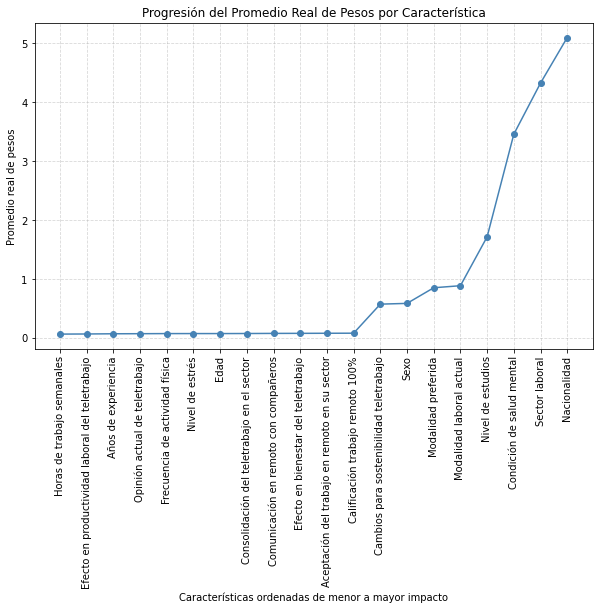

In [42]:
# Ordenar los valores de pesos agrupados de menor a mayor
pesos_ordenados = pesos_agrupados.sort_values(ascending=True)

plt.figure(figsize=(10, 6))

# Graficar la línea con los valores ordenados
plt.plot(pesos_ordenados.values, marker='o', linestyle='-', color='steelblue')

# Añadir etiquetas de características y título
plt.xticks(range(len(pesos_ordenados)), pesos_ordenados.index, rotation=90)
plt.xlabel("Características ordenadas de menor a mayor impacto")
plt.ylabel("Promedio real de pesos")
plt.title("Progresión del Promedio Real de Pesos por Característica")
plt.grid(True, linestyle="--", alpha=0.5)

# Mostrar el gráfico
plt.show()

In [43]:
# Crear un diccionario que mapea cada columna codificada a su variable original
mapeo_vars = {}

cols_codificadas = X.columns.tolist()

# Para OneHotEncoded: buscar las columnas que comienzan con cada variable original
for col in columnas_categoricas_onehotEncoding:
    prefijo = col + '_'
    for c in cols_caracteristicas:
        if c.startswith(prefijo):
            mapeo_vars[c] = col

# Para LabelEncoded: una columna corresponde a una variable
for col in columnas_categoricas_labelEncoding:
    if col in cols_caracteristicas:
        mapeo_vars[col] = col

# Para las demás columnas numéricas
for col in cols_caracteristicas:
    if col not in mapeo_vars:
        mapeo_vars[col] = col 

# Crear DataFrame con pesos
df_pesos = pd.DataFrame(
    pesos_entrada,
    index=cols_codificadas,
    columns=[f"Neurona_{j+1}" for j in range(pesos_entrada.shape[1])]
)

# Calcular el promedio de pesos absolutos por característica codificada
pesos = df_pesos.mean(axis=1)

# Agrupar por variable original
pesos_agrupados = pesos.groupby(mapeo_vars).sum().sort_values(ascending=True)

print("Promedio real de pesos en variables categóricas y numéricas (agrupadas por características):\n")
print(pesos_agrupados)

Promedio real de pesos en variables categóricas y numéricas (agrupadas por características):

Sector laboral                                    -0.115635
Nacionalidad                                      -0.105120
Nivel de estudios                                 -0.022146
Efecto en productividad laboral del teletrabajo   -0.010909
Modalidad laboral actual                          -0.009307
Consolidación del teletrabajo en el sector        -0.005085
Modalidad preferida                               -0.002992
Opinión actual de teletrabajo                     -0.002798
Comunicación en remoto con compañeros             -0.002520
Frecuencia de actividad física                    -0.002329
Horas de trabajo semanales                        -0.002245
Calificación trabajo remoto 100%                  -0.002104
Sexo                                              -0.001193
Efecto en bienestar del teletrabajo                0.000989
Nivel de estrés                                    0.001658
Cambio

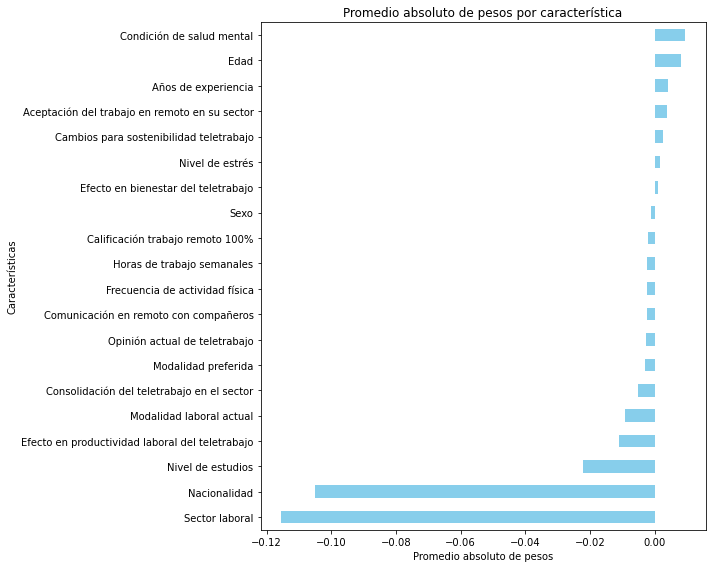

In [44]:
plt.figure(figsize=(10, 8))

# Graficar las barras de pesos
pesos_agrupados.plot(kind="barh", color="skyblue")

# Añadir etiquetas de características y título
plt.xlabel("Promedio absoluto de pesos")
plt.ylabel("Características")
plt.title("Promedio absoluto de pesos por característica")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

### 7. Guardar predicciones en un nuevo dataset:

In [45]:
archivo_excel = 'Dataset_updated (predicciones).xlsx'

# Si el archivo ya existe, eliminarlo para poder reemplazarlo
if os.path.exists(archivo_excel):
    os.remove(archivo_excel)

# Exportar el DataFrame a un archivo Excel
df_pred.to_excel(archivo_excel, index=False)
print("El archivo Excel se ha creado exitosamente, reemplazando el anterior.")

El archivo Excel se ha creado exitosamente, reemplazando el anterior.


### 8. Evaluación de los valores predichos frente a los valores reales:

#### 8.1. Identificación de desviaciones en el modelo.

La línea roja representa la correspondencia ideal entre las predicciones y los valores reales. Cuanto más se acerquen los puntos azules a la línea que muestra la ecuación "y=x", mejor será el rendimiento del modelo. Además, y[col] son los valores reales para la variable 'col' en todo el dataset e y_pred_total[:, i] son las predicciones agregadas para esa misma variable.

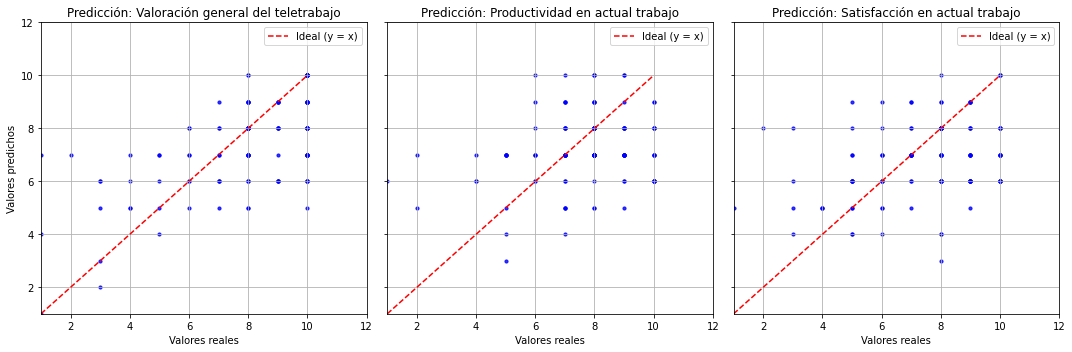

In [46]:
fig, axes = plt.subplots(1, len(variables_objetivo), figsize=(15, 5), sharey=True)

for i, (col, ax) in enumerate(zip(variables_objetivo, axes)):
    
    ax.scatter(y[col], y_pred_total[:, i], alpha=0.8, color='blue', s=10, marker='o')
    
    # Dibujar la línea ideal (y = x)
    ax.plot([1, 10], [1, 10], color='red', linestyle='--', label="Ideal (y = x)")
    
    ax.set_xlabel("Valores reales")
    ax.set_title(f"Predicción: {col}")
    ax.set_xlim(1, 12)
    ax.set_ylim(1, 12)
    ax.grid(True)
    ax.legend()

axes[0].set_ylabel("Valores predichos")
plt.tight_layout()

# Mostrar el gráfico
plt.show()

#### 8.2. Distribución de residuos.

El modelo está capturando de manera correcta la tendencia de los datos, puesto que los errores se distribuyen aleatoriamente alrededor de cero, formando una campana de Gauss.

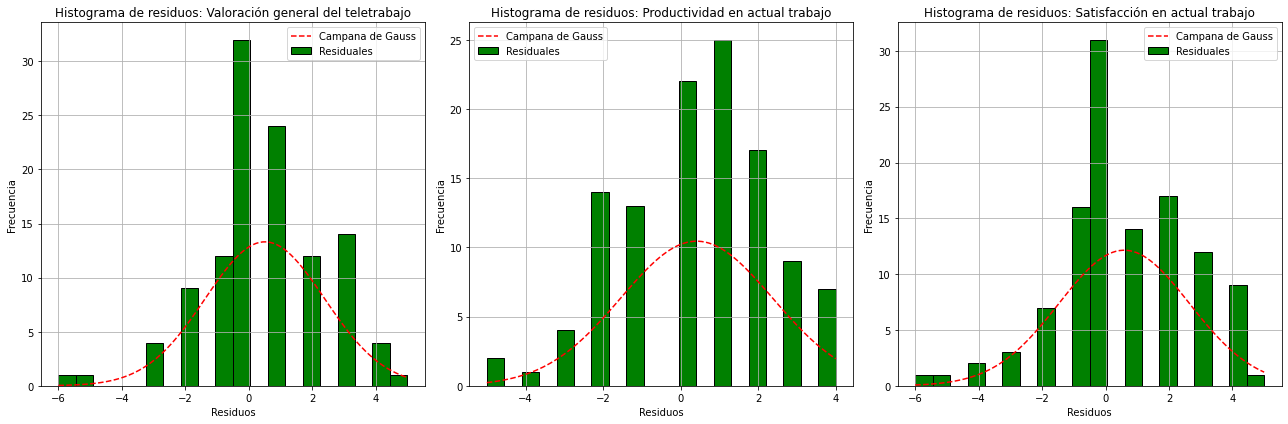

In [47]:
# Crear subgráficas (una por cada variable objetivo)
fig, axes = plt.subplots(1, len(variables_objetivo), figsize=(6 * len(variables_objetivo), 6))

for i, col in enumerate(variables_objetivo):
    # Calcular los residuos: diferencia entre los valores reales y las predicciones
    residuales = y[col].values - y_pred_total[:, i]
    
    ax = axes[i]

    # Graficar el histograma de residuos
    n, bins, patches = ax.hist(residuales, bins=20, color='green', edgecolor='black', label="Residuales")
    
    # Calcular la anchura de las barras del histograma
    bin_width = bins[1] - bins[0]
    
    # Calcular la media y la desviación estándar de los residuos
    mean_ = np.mean(residuales)
    std_ = np.std(residuales)
    
    # Generar valores x que cubran el rango de datos para la curva de Gauss
    x_vals = np.linspace(bins[0], bins[-1], 100)
    
    # Calcular la la campana de Gauss y escalarla para ajustarla al histograma
    y_gauss = norm.pdf(x_vals, mean_, std_) * len(residuales) * bin_width
    
    # Dibujar la campana de Gauss sobre el histograma
    ax.plot(x_vals, y_gauss, 'r--', label="Campana de Gauss")
    ax.set_xlabel("Residuos")
    ax.set_ylabel("Frecuencia")
    ax.set_title(f"Histograma de residuos: {col}")
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()

#### 8.3. Diagramas de caja.

La distribución de los valores reales con los predichos es prácticamente igual, por lo que el modelo ha capturado de manera adecuada la variabilidad de las variables objetivo.

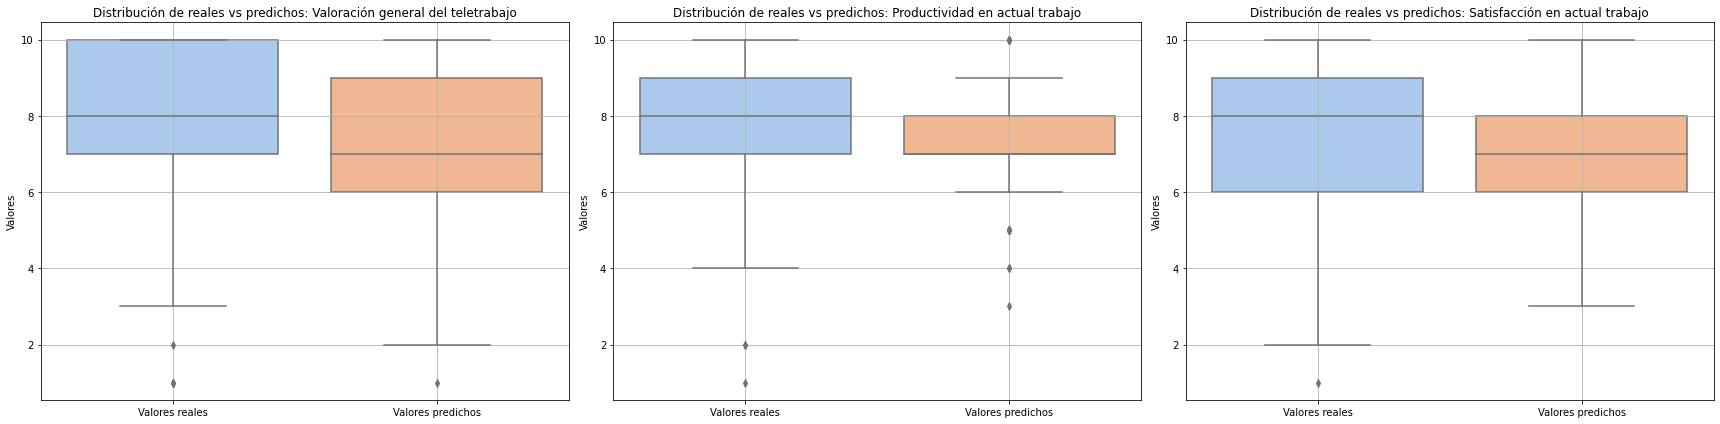

In [48]:
# Crear subgráficas: una por cada variable objetivo
fig, axes = plt.subplots(1, len(variables_objetivo), figsize=(8 * len(variables_objetivo), 6))

for i, col in enumerate(variables_objetivo):
    ax = axes[i]  
    
    # Usar los valores reales del conjunto de entrenamiento y las predicciones acumuladas (y_pred_total)
    sns.boxplot(data=[y[col].values, y_pred_total[:, i]], palette="pastel", ax=ax)
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["Valores reales", "Valores predichos"])
    ax.set_ylabel("Valores")
    ax.set_title(f"Distribución de reales vs predichos: {col}")
    ax.grid(True)

plt.tight_layout()
plt.show()

### 9. Generación de nuevos DataFrames:

#### 9.1. Combinar conjuntos de datos - df_pred y df_original.

Se juntan los registros con las predicciones (df_pred) con los registros sin los valores nulos en las variables objetivo (df_original).

In [49]:
df_original = df_original.dropna(subset=variables_objetivo)

In [50]:
# Reemplazar las filas en df_modif correspondientes a los registros predichos
df_modif.loc[df_pred.index, variables_objetivo] = df_predicciones[variables_objetivo]

In [51]:
display(df_modif.head())

,id,Edad,Años de experiencia,Horas de trabajo semanales,Opinión actual de teletrabajo,Calificación trabajo remoto 100%,Aceptación del trabajo en remoto en su sector,Nivel de estrés,Frecuencia de actividad física,Efecto en productividad laboral del teletrabajo,...,Productividad en actual trabajo,Satisfacción en actual trabajo,Sexo,Nacionalidad,Nivel de estudios,Sector laboral,Modalidad laboral actual,Condición de salud mental,Modalidad preferida,Cambios para sostenibilidad teletrabajo
0,1,22,1.5,8.0,2,2,3,B. Medio,D. 1 día a la semana,2,...,8.0,7.0,Hombre,Española,Estudios universitarios,Tecnología y Ciencia,Híbrido,Sin problema específico,Híbrido,No
1,2,41,20.0,48.0,2,2,3,B. Medio,D. 1 día a la semana,1,...,8.0,8.0,Hombre,Española,Estudios de postgrado,Tecnología y Ciencia,Remoto,Burnout,Híbrido,Sí
2,3,22,2.0,30.0,3,3,3,C. Bajo,D. 1 día a la semana,2,...,7.0,8.0,Hombre,Española,Estudios universitarios,Tecnología y Ciencia,Híbrido,Sin problema específico,Híbrido,No
3,4,22,1.0,43.0,3,2,3,B. Medio,E. Rara vez,2,...,7.0,7.0,Hombre,Española,Estudios universitarios,Tecnología y Ciencia,Remoto,Sin problema específico,Híbrido,Sí
4,5,23,1.0,40.0,1,1,3,C. Bajo,D. 1 día a la semana,2,...,7.0,8.0,Hombre,Española,Estudios universitarios,Tecnología y Ciencia,Híbrido,Sin problema específico,Presencial 100%,Sí


#### 9.2. Creación de un nuevo dataset.

Finalmente, se crea un nuevo conjunto de datos que contiene todos los registros iniciales, los que tenían valor en cada una de las variables objetivo, junto con las filas de los valores que se han predicho.

In [52]:
archivo_excel1 = 'Dataset_completo.xlsx'

# Si el archivo ya existe, eliminarlo para poder reemplazarlo
if os.path.exists(archivo_excel1):
    os.remove(archivo_excel1)

# Exportar el DataFrame a un archivo Excel
df_modif.to_excel(archivo_excel1, index=False)
print("El archivo Excel se ha creado exitosamente, reemplazando el anterior.")

El archivo Excel se ha creado exitosamente, reemplazando el anterior.


### 10. Contraste de hipótesis:

#### 10.1. Impacto de la valoración general del teletrabajo sobre la Productividad y Satisfacción.

Se ha decidido segmentar el análisis según la modalidad laboral actual (remota, presencial o híbrida) para distinguir las diferencias en las correlaciones específicas de cada dinámica, tratando de evitar conclusiones incorrectas. 

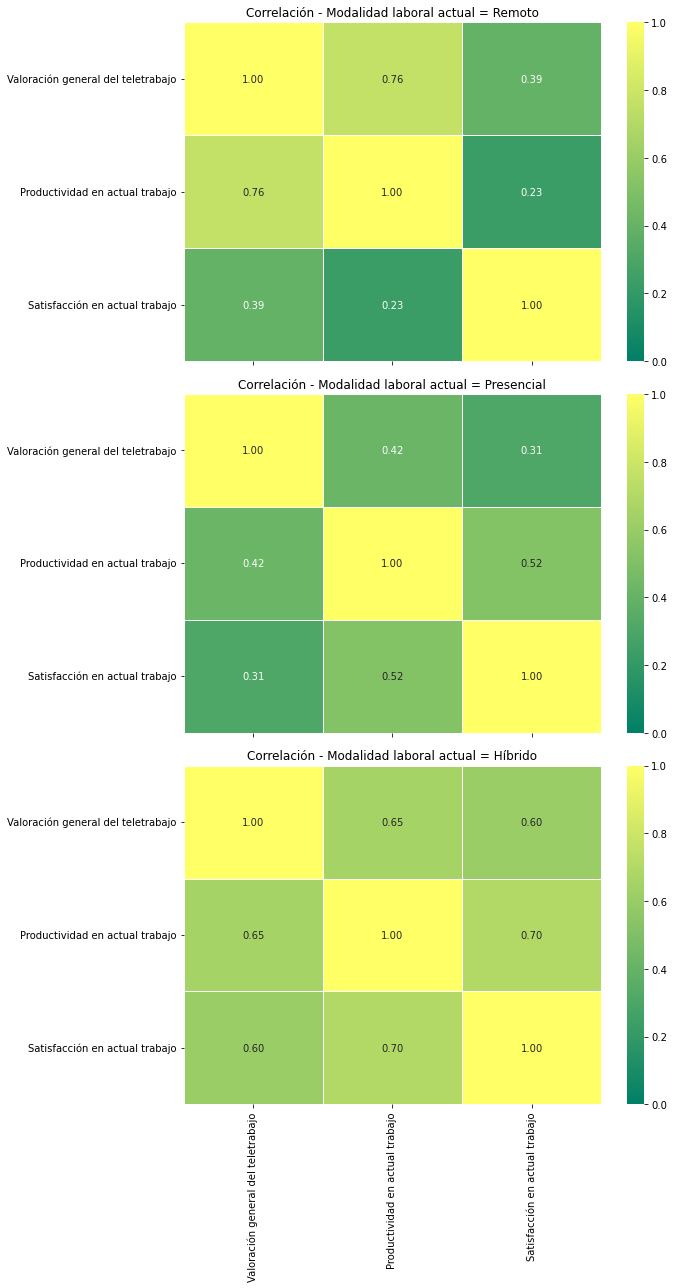

In [53]:
# Lista de variables de interés para el heatmap
variables_interes = [
    "Valoración general del teletrabajo",
    "Productividad en actual trabajo",
    "Satisfacción en actual trabajo"
]

# Filtrar por cada modalidad
df_remoto = df_modif[df_modif["Modalidad laboral actual"] == "Remoto"][variables_interes]
df_presencial = df_modif[df_modif["Modalidad laboral actual"] == "Presencial"][variables_interes]
df_hibrido = df_modif[df_modif["Modalidad laboral actual"] == "Híbrido"][variables_interes]

# Crear figura con tres subplots verticales
fig, axes = plt.subplots(3, 1, figsize=(10, 18))

# Heatmap para la modalidad Remoto
sns.heatmap(
    df_remoto.corr(), 
    annot=True, cmap="summer", vmin=0, vmax=1, fmt=".2f", linewidths=0.5, 
    ax=axes[0]
)
axes[0].set_title("Correlación - Modalidad laboral actual = Remoto")
axes[0].set_xticklabels([])  # Eliminar etiquetas del eje X

# Heatmap para la modalidad Presencial
sns.heatmap(
    df_presencial.corr(), 
    annot=True, cmap="summer", vmin=0, vmax=1, fmt=".2f", linewidths=0.5, 
    ax=axes[1]
)
axes[1].set_title("Correlación - Modalidad laboral actual = Presencial")
axes[1].set_xticklabels([])  # Eliminar etiquetas del eje X

# Heatmap para la modalidad Híbrido (se mantienen las etiquetas del eje X)
sns.heatmap(
    df_hibrido.corr(), 
    annot=True, cmap="summer", vmin=0, vmax=1, fmt=".2f", linewidths=0.5, 
    ax=axes[2]
)
axes[2].set_title("Correlación - Modalidad laboral actual = Híbrido")

# Mostrar el gráfico
plt.tight_layout()
plt.show()

#### 10.2. Asignación de pesos en la predicción de la satisfacción laboral.

El objetivo es comprender cómo se asocian las diferentes características con el nivel de satisfacción mediante un modelo que asigna coeficientes específicos a cada predictor, permitiendo cuantificar el impacto individual sobre las variables dependientes.

In [54]:
# Variables
X = df_modif[['Modalidad laboral actual', 'Edad', 'Sexo', 'Nacionalidad', 'Años de experiencia']]
y = df_modif['Satisfacción en actual trabajo']

# Columnas categóricas y numéricas
cat_features = ['Modalidad laboral actual', 'Sexo', 'Nacionalidad']
num_features = ['Edad', 'Años de experiencia']

# Preprocesamiento con OneHotEncoder y generación de interacciones
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), cat_features),
    ('num', 'passthrough', num_features)
])

# Generación de interacciones con PolynomialFeatures
interaction = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

# Pipeline que integra preprocesamiento, creación de interacciones y regresión lineal
model = Pipeline([
    ('preprocessor', preprocessor),
    ('interactions', interaction),
    ('regressor', LinearRegression())
])

# Entrenar el modelo
model.fit(X, y)

# Extraer nombres de las características después de aplicar las interacciones
nombres_caracteristicas = model.named_steps['interactions'].get_feature_names_out(
    caracteristicas_entrada=model.named_steps['preprocessor'].get_feature_names_out()
)

# Crear DataFrame con coeficientes asociados a cada feature
coef_df = pd.DataFrame({
    'caracteristica': caracteristicas_entrada,
    'coeficiente': model.named_steps['regressor'].coef_
})

# Ordenar las features por la magnitud de sus coeficientes
coef_df = coef_df.sort_values(by='coeficiente', key=abs, ascending=False)

# Excluir las características, cuyo coeficiente es 0
coef_df_filtrado = coef_df[coef_df['coeficiente'] != 0]
print(coef_df_filtrado)

# Guardar el DataFrame filtrado en un archivo Excel
coef_df_filtrado.to_excel('coef_df_filtrado.xlsx', index=False)

print("El DataFrame se ha guardado en 'coef_df_filtrado.xlsx'")

                                        caracteristica  coeficiente
8                         cat__Nacionalidad_Colombiana     7.065329
4                          cat__Nacionalidad_Argentina    -6.012938
67         cat__Sexo_Mujer cat__Nacionalidad_Argentina    -6.012938
39   cat__Modalidad laboral actual_Presencial cat__...    -5.470920
20                        cat__Nacionalidad_Venezolana     5.363856
..                                                 ...          ...
19                            cat__Nacionalidad_Rumana     0.004058
82            cat__Sexo_Mujer cat__Nacionalidad_Rumana     0.004058
272  cat__Nacionalidad_Rumana num__Años de experiencia     0.004058
41   cat__Modalidad laboral actual_Presencial cat__...     0.004058
275                 num__Edad num__Años de experiencia    -0.000338

[110 rows x 2 columns]
El DataFrame se ha guardado en 'coef_df_filtrado.xlsx'


In [55]:
modelo = LinearRegression()
modelo.fit(X_train, y_train)

# Obtener el intercepto
intercepto = modelo.intercept_
print("Intercepto del modelo:", intercepto)

Intercepto del modelo: [7.85579762 7.70853636 7.46167954]


#### 10.3. Adaptabilidad y preferencias sobre las distintas modalidades laborales.

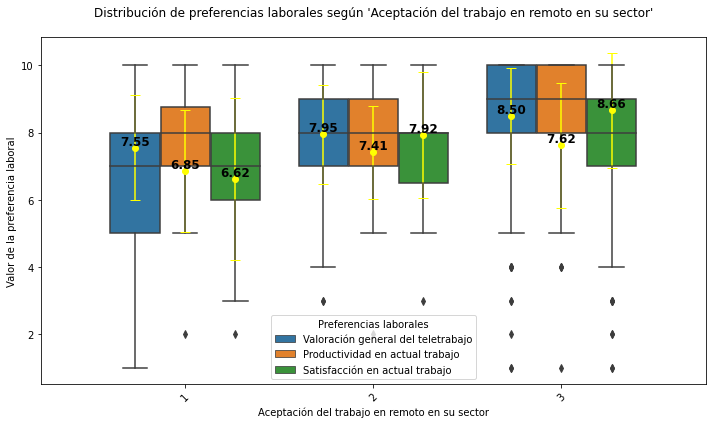

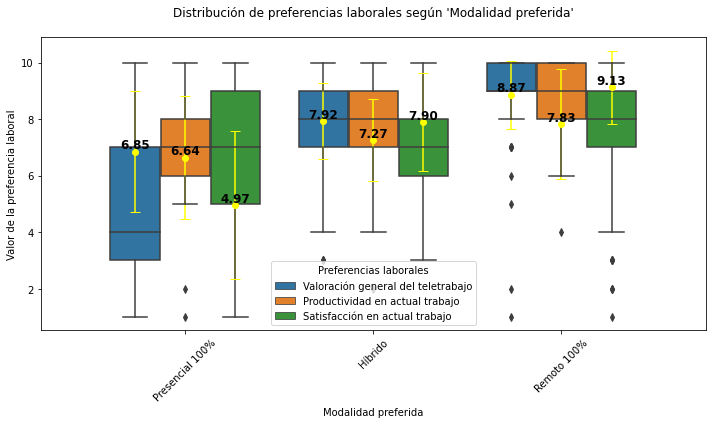

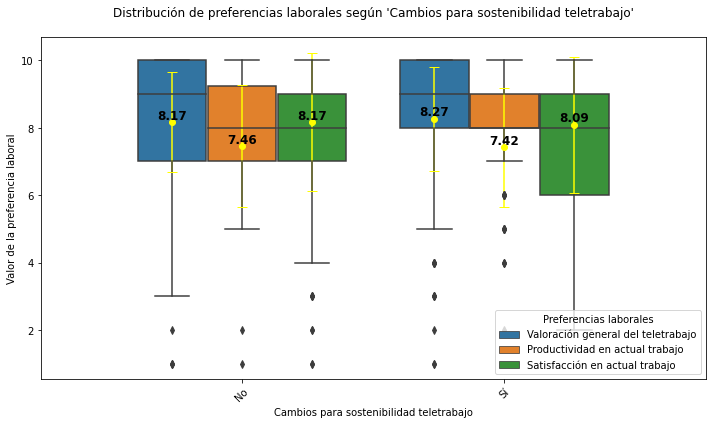

In [67]:
# Define las variables independientes (categóricas) y los outcomes
independent_vars = [
    "Aceptación del trabajo en remoto en su sector", 
    "Modalidad preferida", 
    "Cambios para sostenibilidad teletrabajo"
]
outcome_vars = [
    "Valoración general del teletrabajo", 
    "Productividad en actual trabajo", 
    "Satisfacción en actual trabajo"
]

# Recorrer cada variable independiente para graficarla
for iv in independent_vars:
    
    # Convertir a formato long para facilitar la comparación
    df_long = pd.melt(df_modif, 
                      id_vars=[iv], 
                      value_vars=outcome_vars, 
                      var_name="Preferencias laborales", 
                      value_name="Valor")
    
    plt.figure(figsize=(10, 6))

    # Definir el orden deseado para la variable "Modalidad preferida"
    if iv == "Modalidad preferida":
        cat_order = ["Presencial 100%", "Híbrido", "Remoto 100%"]
    else:
        cat_order = sorted(df_long[iv].unique())

    ax = sns.boxplot(x=iv, y="Valor", hue="Preferencias laborales", data=df_long, order=cat_order)

    # Calcular estadísticas
    stats = df_long.groupby([iv, "Preferencias laborales"])["Valor"].agg(["mean", "std"]).reset_index()

    # Obtener el orden de los niveles para posicionar las medias y desviaciones
    hue_order = sorted(df_long["Preferencias laborales"].unique())
    n_hues = len(hue_order)
    dodge = 0.4
    box_width = (2 * dodge) / n_hues

    # Ubicar correctamente los puntos sobre el gráfico de cajas
    for idx, row in stats.iterrows():
        cat = row[iv]
        hue_val = row["Preferencias laborales"]
        cat_idx = cat_order.index(cat)
        hue_idx = hue_order.index(hue_val)
        x_pos = cat_idx - dodge + (hue_idx + 0.5) * box_width

        # Etiqueta de media
        ax.text(x_pos, row["mean"], f"{row['mean']:.2f}", ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')
        
        # Añadir punto de la media y barra de error
        ax.errorbar(x=x_pos, y=row["mean"], yerr=row["std"], fmt='o', color='yellow', capsize=5)

    # Ajustar leyenda
    handles, labels = ax.get_legend_handles_labels()
    unique_labels, unique_handles = [], []
    for handle, label in zip(handles, labels):
        if label not in unique_labels:
            unique_labels.append(label)
            unique_handles.append(handle)

    plt.title(f"Distribución de preferencias laborales según '{iv}'\n")
    plt.xlabel(iv)
    plt.ylabel("Valor de la preferencia laboral")
    plt.xticks(rotation=45)
    ax.legend(unique_handles, unique_labels, title="Preferencias laborales", loc="best")
    plt.tight_layout()
    
    # Mostrar el gráfico
    plt.show()

La desviación estándar (línea de color amarillo) indica la variabilidad en los datos alrededor de la media. Cuanto mayor sean estas líneas, mayor será la dispersión de los datos, lo que significa que hay más variabilidad en cómo los trabajadores perciben su productividad y satisfacción en las dinámicas laborales.

#### 10.4. Impacto del nivel de estrés, la condición de salud mental y la frecuencia de actividad física.

El objetivo es observar el impacto de la productividad en la valoración del teletrabajo, sin excluir la necesidad de prestar atención al manejo del estrés, al cuidado de la salud mental y al inicio de hábitos saludables como la actividad física.

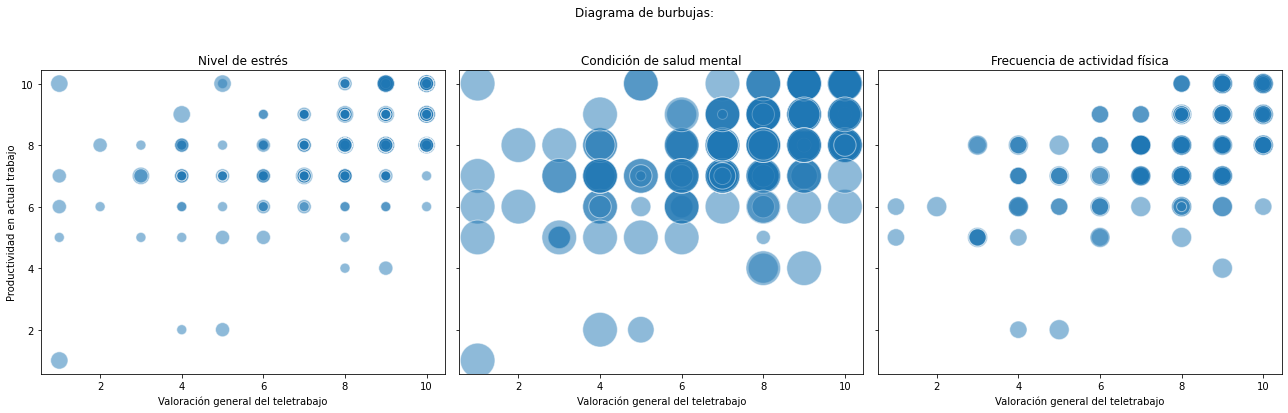

In [73]:
# Variables a usar
vars_ = ["Nivel de estrés", "Condición de salud mental", "Frecuencia de actividad física"]
x_var = "Valoración general del teletrabajo"
y_var = "Productividad en actual trabajo"

# Crear el diagrama de burbujas
fig, axes = plt.subplots(1, len(vars_), figsize=(18, 6), sharex=True, sharey=True)

for i, w in enumerate(vars_):
    
    # Determinar el tamaño de las burbujas en función de la variable de bienestar
    if pd.api.types.is_numeric_dtype(df_modif[w]):
        bubble_sizes = df_completo[w].copy()
        scaling_factor = 50  # Ajusta este factor según convenga
        bubble_sizes = bubble_sizes * scaling_factor
    else:
        
        # Convertir la variable categórica a códigos numéricos
        bubble_sizes = pd.Categorical(df_modif[w]).codes.astype(float)
        scaling_factor = 100  # Factor de escalado para variables categóricas
        bubble_sizes = bubble_sizes * scaling_factor

    ax = axes[i]
    sc = ax.scatter(df_modif[x_var], df_modif[y_var], 
                    s=bubble_sizes,       # Tamaño de la burbuja
                    alpha=0.5, 
                    edgecolors='w')

    ax.set_title(w)
    ax.set_xlabel(x_var)
    if i == 0:
        ax.set_ylabel(y_var)

plt.suptitle("Diagrama de burbujas:")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()